# Phase-estimation and factoring

## Table of Contents

- [Introduction](#introduction)
- [The phase estimation problem](#the-phase-estimation-problem)
    - [Spectral theorem](#spectral-theorem)
    - [Phase estimation problem statement](#phase-estimation-problem-statement)
- [Phase estimation procedure](#phase-estimation-procedure)
    - [Warm-up: approximating phases with low precision](#warm-up-approximating-phases-with-low-precision)
    - [Quantum Fourier transform](#quantum-fourier-transform)
    - [General procedure and analysis](#general-procedure-and-analysis)
- [Shor's algorithm](#shors-algorithm)
    - [Order finding](#order-finding)
    - [Factoring by order-finding](#factoring-by-order-finding)
    - [Implementation in Qiskit](#implementation-in-qiskit)


## [Introduction](#introduction)
In this lesson we'll discuss the phase estimation problem and how to solve it with a quantum computer. We'll then use this solution to obtain *Shor's algorithm* — an efficient quantum algorithm for the integer factorization problem. Along the way, we'll encounter the quantum Fourier transform, and we'll see how it can be implemented efficiently by a quantum circuit.

## [The phase estimation problem](#the-phase-estimation-problem)
This section explains the phase estimation problem. We'll begin with a short discussion of the spectral theorem from linear algebra, and then move on to a statement of the phase estimation problem itself.

### [Spectral theorem](#spectral-theorem)

The *spectral theorem* is an important fact from linear algebra that states that matrices of a certain type, called *normal matrices*, can be expressed in a simple and useful way. We'll only need this theorem for unitary matrices in this lesson, but in later lessons we'll apply it to Hermitian matrices as well.

#### Normal matrices

A square matrix $M$ with complex number entries is said to be a *normal* matrix if it commutes with its conjugate transpose:  
$$
MM^\dagger = M^\dagger M.
$$

Every unitary matrix $U$ is normal because  
$$
UU^\dagger = I = U^\dagger U.
$$

Hermitian matrices, which are matrices that equal their own conjugate transpose, are another important class of normal matrices.  
If $H$ is a Hermitian matrix, then  
$$
HH^\dagger = H^2 = H^\dagger H,
$$  
so $H$ is normal.

Not every square matrix is normal. For instance, this matrix isn’t normal:  
$$
\begin{pmatrix} 0 & 1 \\ 0 & 0 \end{pmatrix}
$$

(This is a simple but great example of a matrix that’s often very helpful to consider.) It isn’t normal because  
$$
\begin{pmatrix} 0 & 1 \\ 0 & 0 \end{pmatrix}
\begin{pmatrix} 0 & 0 \\ 1 & 0 \end{pmatrix}
= \begin{pmatrix} 1 & 0 \\ 0 & 0 \end{pmatrix}
\quad \text{while} \quad
\begin{pmatrix} 0 & 0 \\ 1 & 0 \end{pmatrix}
\begin{pmatrix} 0 & 1 \\ 0 & 0 \end{pmatrix}
= \begin{pmatrix} 0 & 0 \\ 0 & 1 \end{pmatrix}.
$$

#### Theorem statement

Now here's a statement of the spectral theorem.

> **Theorem (spectral theorem).** Let $M$ be a normal $N \times N$ complex matrix. There exists an orthonormal basis of $N$-dimensional complex vectors $\{|\psi_1\rangle, \ldots, |\psi_N\rangle\}$ along with complex numbers $\lambda_1, \ldots, \lambda_N$ such that  
> $$
> M = \lambda_1 |\psi_1\rangle \langle \psi_1| + \cdots + \lambda_N |\psi_N\rangle \langle \psi_N|.
> $$

The expression of a matrix in the form  
$$
M = \sum_{k=1}^{N} \lambda_k |\psi_k\rangle \langle \psi_k| \tag{1}
$$  
is commonly called a *spectral decomposition*. Notice that if $M$ is a normal matrix expressed in the form (1), then the equation  
$$
M|\psi_j\rangle = \lambda_j |\psi_j\rangle
$$  
must be true for every $j = 1, \ldots, N$. This is a consequence of the fact that $\{|\psi_1\rangle, \ldots, |\psi_N\rangle\}$ is orthonormal:  
$$
M|\psi_j\rangle = \left(\sum_{k=1}^{N} \lambda_k |\psi_k\rangle \langle \psi_k| \right)|\psi_j\rangle
= \sum_{k=1}^{N} \lambda_k |\psi_k\rangle \langle \psi_k | \psi_j \rangle
= \lambda_j |\psi_j\rangle
$$

That is, each number $\lambda_j$ is an *eigenvalue* of $M$ and $|\psi_j\rangle$ is an *eigenvector* corresponding to that eigenvalue.

---

### Example 1
Let  
$$
\mathbb{I} = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix},
$$  
which is normal. The theorem implies that $\mathbb{I}$ can be written in the form (1) for some choice of $\lambda_1$, $\lambda_2$, $|\psi_1\rangle$, and $|\psi_2\rangle$. There are multiple choices that work, including  
$$
\lambda_1 = 1,\quad \lambda_2 = 1,\quad |\psi_1\rangle = |0\rangle,\quad |\psi_2\rangle = |1\rangle.
$$

Notice that the theorem does not say that the complex numbers $\lambda_1, \ldots, \lambda_n$ are distinct — we can have the same complex number repeated, which is necessary for this example. These choices work because  
$$
\mathbb{I} = |0\rangle \langle 0| + |1\rangle \langle 1|.
$$

Indeed, we could choose $\{|\psi_1\rangle, |\psi_2\rangle\}$ to be *any* orthonormal basis and the equation will be true. For instance,  
$$
\mathbb{I} = |+\rangle \langle +| + |-\rangle \langle -|.
$$

---

### Example 2
Consider a Hadamard operation:  
$$
H = \frac{1}{\sqrt{2}} \begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix}.
$$  
This is a unitary matrix, so it is normal. The spectral theorem implies that $H$ can be written in the form (1), and in particular we have  
$$
H = |\psi_{\pi/8}\rangle \langle \psi_{\pi/8}| - |\psi_{7\pi/8}\rangle \langle \psi_{7\pi/8}|
$$  
where  
$$
|\psi_\theta\rangle = \cos(\theta) |0\rangle + \sin(\theta) |1\rangle.
$$

More explicitly,

$$
|\psi_{\pi/8}\rangle = \frac{\sqrt{2 + \sqrt{2}}}{2} |0\rangle + \frac{\sqrt{2 - \sqrt{2}}}{2} |1\rangle,
$$  
$$
|\psi_{7\pi/8}\rangle = -\frac{\sqrt{2 - \sqrt{2}}}{2} |0\rangle + \frac{\sqrt{2 + \sqrt{2}}}{2} |1\rangle.
$$

We can check that this decomposition is correct by performing the required calculations:  
$$
|\psi_{\pi/8}\rangle \langle \psi_{\pi/8}| - |\psi_{7\pi/8}\rangle \langle \psi_{7\pi/8}| =
\begin{pmatrix}
\frac{2 + \sqrt{2}}{4} & \frac{\sqrt{2}}{4} \\
\frac{\sqrt{2}}{4} & \frac{2 - \sqrt{2}}{4}
\end{pmatrix}
-
\begin{pmatrix}
\frac{2 - \sqrt{2}}{4} & -\frac{\sqrt{2}}{4} \\
-\frac{\sqrt{2}}{4} & \frac{2 + \sqrt{2}}{4}
\end{pmatrix}
= H.
$$

Alternatively, we can use Qiskit to check that this decomposition is correct.


In [1]:
from qiskit import __version__
print(__version__)

2.0.0


In [2]:
from qiskit.quantum_info import Statevector
from qiskit.quantum_info.operators import Operator
from math import pi, cos, sin

In [3]:
psi1 = Statevector([cos(pi / 8), sin(pi / 8)])
psi2 = Statevector([cos(5 * pi / 8), sin(5 * pi / 8)])

# When given a Statevector input, the Operator function returns the outer
# product of that state vector with itself — or, in other words, the
# product of the vector times its conjugate transpose.

H = Operator(psi1) - Operator(psi2)
display(H.draw("latex"))

<IPython.core.display.Latex object>

As the first example above reveals, there can be some freedom in how eigenvectors are selected. There is, however, no freedom at all in how the eigenvalues are chosen, except for their ordering; the same $N$ complex numbers $\lambda_1, \ldots, \lambda_N$, which can include repetitions of the same complex number, will always occur in the equation (1) for a given choice of a matrix $M$.

Now let's focus in on unitary matrices. Suppose we have a complex number $\lambda$ and a non-zero vector $|\psi\rangle$ that satisfy the equation  
$$
U|\psi\rangle = \lambda |\psi\rangle. \tag{2}
$$

That is, $\lambda$ is an eigenvalue of $U$ and $|\psi\rangle$ is an eigenvector corresponding to this eigenvalue.

Unitary matrices preserve Euclidean norm, and so we conclude the following from (2):  
$$
\|\ |\psi\rangle \| = \|U|\psi\rangle \| = |\lambda| \|\psi\rangle \| = |\lambda| \|\ |\psi\rangle \|
$$

The condition that $|\psi\rangle$ is non-zero implies that $\|\ |\psi\rangle \| \neq 0$, so we can cancel it from both sides to obtain  
$$
|\lambda| = 1.
$$

This reveals that eigenvalues of unitary matrices must always have absolute value equal to one, so they lie on the *unit circle*:  
$$
\mathbb{T} = \{ \alpha \in \mathbb{C} : |\alpha| = 1 \}
$$

(The symbol $\mathbb{T}$ is a common name for the complex unit circle. The name $S^1$ is also common.)



### [Phase estimation problem statement](#phase-estimation-problem-statement)

In the *phase estimation problem*, we're given a quantum state $|\psi\rangle$ of $n$ qubits, along with a unitary quantum circuit that acts on $n$ qubits. We're **promised** that $|\psi\rangle$ is an eigenvector of the unitary matrix $U$ that describes the action of the circuit, and our goal is to compute or approximate the eigenvalue $\lambda$ to which $|\psi\rangle$ corresponds. More precisely, because $\lambda$ lies on the complex unit circle, we can write  
$$
\lambda = e^{2\pi i \theta}
$$  
for a unique real number $\theta$ satisfying $0 \leq \theta < 1$. The goal of the problem is to compute or approximate this real number $\theta$.

> **Phase estimation problem**  
> Input: A unitary quantum circuit for an $n$-qubit operation $U$ along with an $n$-qubit quantum state $|\psi\rangle$  
> Promise: $|\psi\rangle$ is an eigenvector of $U$  
> Output: an approximation to the number $\theta \in [0,1)$ satisfying $U|\psi\rangle = e^{2\pi i \theta} |\psi\rangle$

## Remarks

1. The phase estimation problem is different from other problems we've seen so far in the course in that the input includes a quantum state. Typically we've focused on problems having classical inputs and outputs, but nothing prevents us from considering quantum state inputs like this. In terms of its practical relevance, the phase estimation problem is typically encountered as a *subproblem* inside of a larger computation, like we'll see in the context of integer factorization later in the lesson.

2. The statement of the phase estimation problem above isn't specific about what constitutes an approximation of $\theta$, but we can formulate more precise problem statements depending on our needs and interests. In the context of integer factorization, we'll demand a very precise approximation to $\theta$, but in other cases we might be satisfied with a very rough approximation. We'll discuss shortly how the precision we require affects the computational cost of a solution.

3. Notice that as we go from $\theta = 0$ toward $\theta = 1$ in the phase estimation problem, we're going all the way around the unit circle, starting from $e^{2\pi i \cdot 0} = 1$ and moving counter-clockwise toward $e^{2\pi i \cdot 1} = 1$. That is, when we reach $\theta = 1$ we're back where we started at $\theta = 0$. So, as we consider the accuracy of approximations, choices of $\theta$ near 1 should be considered as being near 0. For example, an approximation $\theta = 0.999$ should be considered as being within $1/1000$ of $\theta = 0$.



## [Phase estimation procedure](#phase-estimation-procedure)

Next we'll discuss the *phase-estimation procedure*, which is a quantum algorithm for solving the phase estimation problem. We'll begin with a low-precision warm-up, which explains some of the basic intuition behind the method. We'll then talk about the *quantum Fourier transform*, which is an important quantum operation used in the phase-estimation procedure, as well as its quantum circuit implementation. Once we have the quantum Fourier transform in hand, we'll describe the phase-estimation procedure in full generality and analyze its performance.



### [Warm-up: approximating phases with low precision](#warm-up-approximating-phases-with-low-precision)

We'll begin with a couple of simple versions of the phase-estimation procedure that provide low-precision solutions to the phase-estimation problem. This is helpful for explaining the intuition behind the general procedure that we'll see a bit later in the lesson.

#### Using the phase kickback

A simple approach to the phase-estimation problem, which allows us to learn something about the value $\theta$ we seek, is based on the *phase kickback* phenomenon. As we'll see, this is essentially a single-qubit version of the general phase-estimation procedure to be discussed later in the lesson.

As part of the input to the phase estimation problem, we have a unitary quantum circuit for the operation $U$. We can use the description of this circuit to create a circuit for a *controlled-$U$* operation, which can be depicted as this figure suggests (with the operation $U$, viewed as a quantum gate, on the left and a controlled-$U$ operation on the right).

![uncontrolled-and-controlled-unitary.png](attachment:uncontrolled-and-controlled-unitary.png)

We can create a quantum circuit for a controlled-$U$ operation by first adding a control qubit to the circuit for $U$, and then replacing every gate in the circuit for $U$ with a controlled version of that gate — so our one new control qubit effectively controls every single gate in the circuit for $U$. This requires that we have a controlled version of every gate in our circuit, but we can always build circuits for these controlled operations in case they're not included in our gate set.

Now consider the following circuit, where the input state $|\psi\rangle$ of all of the qubits except the top one is the quantum state eigenvector of $U$:


![estimate-phase-with-kickback.png](attachment:estimate-phase-with-kickback.png)

The measurement outcome probabilities for this circuit depend on the eigenvalue of 
$U$ corresponding to the eigenvector $∣ψ⟩$ Let's analyze the circuit in detail to determine exactly how.

![estimate-phase-with-kickback-analysis.png](attachment:estimate-phase-with-kickback-analysis.png)

The initial state of the circuit is

$$
|\pi_0\rangle = |\psi\rangle |0\rangle
$$

and the first Hadamard gate transforms this state to

$$
|\pi_1\rangle = |\psi\rangle |+\rangle = \frac{1}{\sqrt{2}} |\psi\rangle |0\rangle + \frac{1}{\sqrt{2}} |\psi\rangle |1\rangle.
$$

Next, the controlled-$U$ operation is performed, which results in the state

$$
|\pi_2\rangle = \frac{1}{\sqrt{2}} |\psi\rangle |0\rangle + \frac{1}{\sqrt{2}} (U|\psi\rangle) |1\rangle.
$$

Using the assumption that $|\psi\rangle$ is an eigenvector of $U$ having eigenvalue $\lambda = e^{2\pi i \theta}$, we can alternatively express this state as follows:

$$
|\pi_2\rangle = \frac{1}{\sqrt{2}} |\psi\rangle |0\rangle + \frac{e^{2\pi i \theta}}{\sqrt{2}} |\psi\rangle |1\rangle = |\psi\rangle \otimes \left(\frac{1}{\sqrt{2}} |0\rangle + \frac{e^{2\pi i \theta}}{\sqrt{2}} |1\rangle\right)
$$

Here we observe the phase kickback phenomenon. It is slightly different this time than it was for Deutsch's algorithm and the Deutsch-Jozsa algorithm because we're not working with a query gate — but the idea is the same.

Finally, the second Hadamard gate is performed. After just a bit of simplification, we obtain this expression for this state:

$$
|\pi_3\rangle = |\psi\rangle \otimes \left(\frac{1 + e^{2\pi i \theta}}{2} |0\rangle + \frac{1 - e^{2\pi i \theta}}{2} |1\rangle \right)
$$

The measurement therefore yields the outcomes 0 and 1 with these probabilities:

$$
p_0 = \left| \frac{1 + e^{2\pi i \theta}}{2} \right|^2 = \cos^2(\pi \theta)
$$

$$
p_1 = \left| \frac{1 - e^{2\pi i \theta}}{2} \right|^2 = \sin^2(\pi \theta)
$$

Here's a plot of the probabilities for the two possible outcomes, 0 and 1, as functions of the value $\theta$.

![kickback-probabilities.png](attachment:kickback-probabilities.png)

Naturally, the two probabilities always sum to 1. Notice that when $\theta = 0$, the measurement outcome is always 0, and when $\theta = \frac{1}{2}$, the measurement outcome is always 1. So, although the measurement result doesn't reveal exactly what $\theta$ is, it does provide us with some information about it — and if we were promised that either $\theta = 0$ or $\theta = \frac{1}{2}$, we could learn from the circuit which one is correct without error.

Intuitively speaking, we can think of the circuit's measurement outcome as being a guess for $\theta$ to "one bit of accuracy." In other words, if we were to write $\theta$ in _binary notation_ and round it off to one bit after the _binary point_, we'd have a number like this:

$$
0.a = \begin{cases}
0 & a = 0 \\
\frac{1}{2} & a = 1.
\end{cases}
$$

The measurement outcome can be viewed as a guess for the bit $a$. When $\theta$ is neither 0 nor $\frac{1}{2}$, there's a nonzero probability that the guess will be wrong — but the probability of making an error becomes smaller and smaller as we get closer to 0 or $\frac{1}{2}$.

---

It's natural to ask what role the two Hadamard gates play in this procedure:

– The first Hadamard gate sets the control qubit to a uniform superposition of $|0\rangle$ and $|1\rangle$, so that when the phase kickback occurs, it happens for the $|1\rangle$ state and not the $|0\rangle$ state, creating a _relative_ phase difference that affects the measurement outcomes. If we didn’t do this and the phase kickback produced a _global_ phase, it would have no effect on the probabilities of obtaining different measurement outcomes.

– The second Hadamard gate allows us to learn something about the number $\theta$ through the phenomenon of _interference_. Prior to the second Hadamard gate, the state of the top qubit is

$$
\frac{1}{\sqrt{2}} |0\rangle + \frac{e^{2\pi i \theta}}{\sqrt{2}} |1\rangle,
$$

and if we were to measure this state, we would obtain 0 and 1 each with probability 1/2, telling us nothing about $\theta$. By performing the second Hadamard gate, however, we cause the number $\theta$ to affect the output probabilities.



In [4]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from math import pi, cos, sin

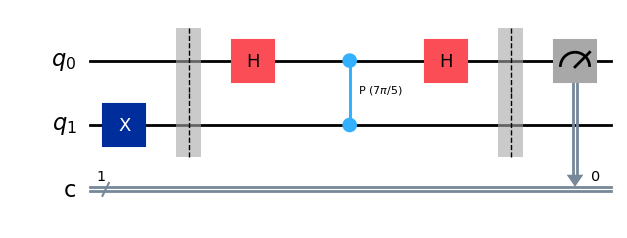

In [5]:
# For this implementation we'll use a phase gate for the unitary operation in the interest of simplicity — so the relevant eigenvector is the ∣1⟩ state.
theta = 0.7  # Can be changed to any value between 0 and 1
qc = QuantumCircuit(2, 1)

# Prepare the eigenvector, which is the |1> state
qc.x(1)
qc.barrier()

# Implement the estimation procedure
qc.h(0)
qc.cp(2 * pi * theta, 0, 1)
qc.h(0)
qc.barrier()

# Perform the final measurement
qc.measure(0, 0)

# Draw the circuit
display(qc.draw(output="mpl"))

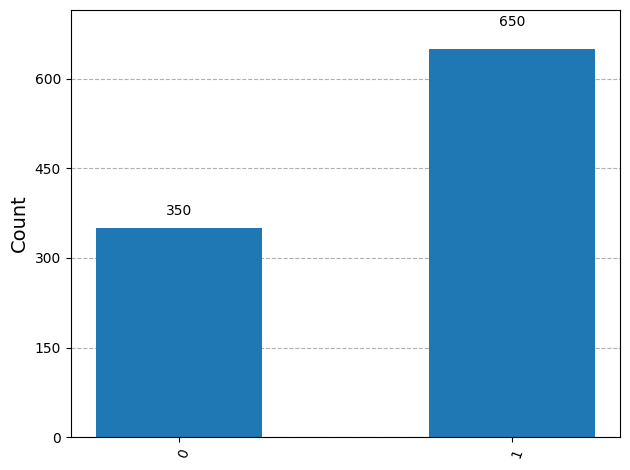

In [6]:
# Now we'll simulate the circuit using the Aer simulator.
result = AerSimulator().run(qc, shots = 1000).result()
statistics = result.get_counts()
display(plot_histogram(statistics))

In [7]:
# Comparison between results and predicted values
print(f"cos(pi * {theta})**2 = {cos(pi * theta) ** 2:.4f}")
print(f"sin(pi * {theta})**2 = {sin(pi * theta) ** 2:.4f}")

cos(pi * 0.7)**2 = 0.3455
sin(pi * 0.7)**2 = 0.6545


#### Doubling the phase
The circuit above uses the phase kickback phenomenon to approximate $\theta$ to a single bit of accuracy. One bit of accuracy may be all we need in some situations — but for factoring we're going to need a lot more accuracy than that. The natural question is, how can we learn more about 
$\theta$ ?

One very simple thing we can do is to replace the controlled-$U$ operation in our circuit with two copies of this operation, like in this circuit:



Two copies of a controlled-$U$ operation is equivalent to a controlled-$U^2$ operation. If $\left|\psi\right\rangle$ is an eigenvector of $U$ having eigenvalue $\lambda = e^{2\pi i \theta}$, then this state is also an eigenvector of $U^2$, this time having eigenvalue $\lambda^2 = e^{2\pi i (2\theta)}$.

So, if we run this version of the circuit, we're effectively performing the same computation as before, except that the number $\theta$ is replaced by $2\theta$. The following plot illustrates the output probabilities as $\theta$ ranges from $0$ to $1$.




Doing this can indeed provide us with some additional information about $\theta$. If the binary representation of $\theta$ is

$$\theta = 0.a_1 a_2 a_3 \cdots$$

then doubling $\theta$ effectively shifts the binary point one position to the right:

$$2\theta = a_1.a_2 a_3 \cdots$$

And because we're equating $\theta = 1$ with $\theta = 0$ as we move around the unit circle, we see that the bit $a_1$ has no influence on our probabilities, and we're effectively obtaining a guess for the *second bit* after the binary point if we round $\theta$ to two bits. For instance, if we knew in advance that $\theta$ was either $0$ or $1/4$, then we could fully trust the measurement outcome to tell us which.

It's not immediately clear, though, how this estimation should be reconciled with what we learned from the original (non-doubled) phase kickback circuit to give us the most accurate information possible about $\theta$. So let's take a step back and consider how to proceed.

#### Two-qubit phase estimation

Rather than considering the two options described above separately, let's combine them into a single circuit like this:



The Hadamard gates after the controlled operations have been removed and there are no measurements here yet. We'll add more to the circuit as we consider our options for learning as much as we can about $\theta$.

If we run this circuit when $|\psi\rangle$ is an eigenvector of $U$, the state of the bottom qubits will remain $|\psi\rangle$ throughout the entire circuit, and phases will be "kicked" into the state of the top two qubits. Let's analyze the circuit carefully, by means of the following figure.




We can write the state $|\pi_1\rangle$ like this:

$$
|\pi_1\rangle = |\psi\rangle \otimes \frac{1}{2} \sum_{a_1=0}^1 \sum_{a_0=0}^1 |a_1 a_0\rangle.
$$

When the first controlled-$U$ operation is performed, the eigenvalue $\lambda = e^{2\pi i \theta}$ gets kicked into the phase when $a_0$ (the top qubit) is equal to 1, but not when it's 0. So, we can express the resulting state like this:

$$
|\pi_2\rangle = |\psi\rangle \otimes \frac{1}{2} \sum_{a_1=0}^1 \sum_{a_0=0}^1 e^{2\pi i a_0 \theta} |a_1 a_0\rangle.
$$

The second and third controlled-$U$ gates do something similar, except for $a_1$ rather than $a_0$, and with $\theta$ replaced by $2\theta$. We can express the resulting state like this:

$$
|\pi_3\rangle = |\psi\rangle \otimes \frac{1}{2} \sum_{a_1=0}^1 \sum_{a_0=0}^1 e^{2\pi i(2a_1+\theta a_0)} |a_1 a_0\rangle.
$$

If we think about the binary string $a_1 a_0$ as representing an integer $x \in \{0, 1, 2, 3\}$ in binary notation, which is $x = 2a_1 + a_0$, we can alternatively express this state as follows.

$$
|\pi_3\rangle = |\psi\rangle \otimes \frac{1}{2} \sum_{x=0}^3 e^{2\pi i x \theta} |x\rangle
$$

---

Our goal is to extract as much information about $\theta$ as we can from this state.

At this point we'll consider a special case, where we're promised that $\theta = \frac{y}{4}$ for some integer $y \in \{0, 1, 2, 3\}$. In other words, we have $\theta \in \{0, 1/4, 1/2, 3/4\}$, so we can express this number exactly using binary notation with two bits, as .00, .01, .10, or .11. In general, $\theta$ might not be one of these four values, but thinking about this special case will help us to figure out how to most effectively extract information about $\theta$ in general.

First we’ll define a two-qubit state vector for each possible value $y \in \{0, 1, 2, 3\}$.

$$
|\phi_y\rangle = \frac{1}{2} \sum_{x=0}^3 e^{2\pi i \frac{yx}{4}} |x\rangle = \frac{1}{2} \sum_{x=0}^3 e^{2\pi i \frac{yx}{4}} |x\rangle
$$

After simplifying the exponentials, we can write these vectors as follows.

$$
|\phi_0\rangle = \frac{1}{2}|0\rangle + \frac{1}{2}|1\rangle + \frac{1}{2}|2\rangle + \frac{1}{2}|3\rangle
$$

$$
|\phi_1\rangle = \frac{1}{2}|0\rangle + \frac{i}{2}|1\rangle - \frac{1}{2}|2\rangle - \frac{i}{2}|3\rangle
$$

$$
|\phi_2\rangle = \frac{1}{2}|0\rangle - \frac{1}{2}|1\rangle + \frac{1}{2}|2\rangle - \frac{1}{2}|3\rangle
$$

$$
|\phi_3\rangle = \frac{1}{2}|0\rangle - \frac{i}{2}|1\rangle - \frac{1}{2}|2\rangle + \frac{i}{2}|3\rangle
$$

These vectors are orthogonal: if we choose any pair of them and compute their inner product, we get 0. Each one is also a unit vector, so $\{|\phi_0\rangle, |\phi_1\rangle, |\phi_2\rangle, |\phi_3\rangle\}$ is an orthonormal basis. We therefore know right away that there is a measurement that can discriminate them perfectly — meaning that, if we’re given one of them but we don’t know which, then we can figure out which one it is without error.

To perform such a discrimination with a quantum circuit, we can first define a unitary operation $V$ that transforms standard basis states into the four states listed above.

$$
\begin{aligned}
V|00\rangle &= |\phi_0\rangle \\
V|01\rangle &= |\phi_1\rangle \\
V|10\rangle &= |\phi_2\rangle \\
V|11\rangle &= |\phi_3\rangle
\end{aligned}
$$

To write down $V$ as a $4 \times 4$ matrix, it's just a matter of taking the columns of $V$ to be the states $|\phi_0\rangle, \dots, |\phi_3\rangle$:

$$
V = \frac{1}{2} \begin{pmatrix}
1 & 1 & 1 & 1 \\
1 & i & -1 & -i \\
1 & -1 & 1 & -1 \\
1 & -i & -1 & i
\end{pmatrix}
$$

This is a special matrix, and it's likely that some readers will have encountered it before: it's the matrix associated with the 4-dimensional *discrete Fourier transform*. In light of this fact, let us call it by the name $\text{QFT}_4$ rather than $V$. The name QFT is short for *quantum Fourier transform* — which is essentially just the discrete Fourier transform, viewed as a unitary operation. We'll discuss the quantum Fourier transform in greater detail and generality shortly.

$$
\text{QFT}_4 = \frac{1}{2} \begin{pmatrix}
1 & 1 & 1 & 1 \\
1 & i & -1 & -i \\
1 & -1 & 1 & -1 \\
1 & -i & -1 & i
\end{pmatrix}
$$

We can perform the inverse of this operation to go the other way, to transform the states $|\phi_0\rangle, \dots, |\phi_3\rangle$ into the standard basis states $|0\rangle, \dots, |3\rangle$. If we do this, then we can measure to learn which value $y \in \{0, 1, 2, 3\}$ describes $\theta$ as $\theta = y/4$.




To summarize, if we run this circuit when $\theta = y / 4$ for $y \in \{0, 1, 2, 3\}$, the state immediately before the measurements take place will be $|\psi\rangle |y\rangle$ (for $y$ encoded as a two-bit binary string), so the measurements will reveal the value $y$ without error.

This circuit is motivated by the special case that $\theta \in \{0, 1/4, 1/2, 3/4\}$ — but we can run it for any choice of $U$ and $|\psi\rangle$, and hence any value of $\theta$, that we wish. Here's a plot of the output probabilities the circuit produces for arbitrary choices of $\theta$:



This is a clear improvement over the single-qubit variant described earlier in the lesson. It's not perfect — it can give us the wrong answer — but the answer is heavily skewed toward values of $y$ for which $y/4$ is close to $\theta$. In particular, the most likely outcome always corresponds to the closest value of $y/4$ to $\theta$ (equating $\theta = 0$ and $\theta = 1$ as before), and from the plot it looks like this closest value for $x$ always appears with probability just above 40%. When $\theta$ is exactly halfway between two such values, like $\theta = 0.375$ for instance, the two equally close values of $y$ are equally likely.



#### Qiskit implementation

Here's an implementation of this procedure in Qiskit, which requires the same imports as the previous implementation above.  
Similar to that implementation, we'll use a phase gate with a chosen angle $\theta$ for the unitary operation and $|1\rangle$ for the eigenvector.



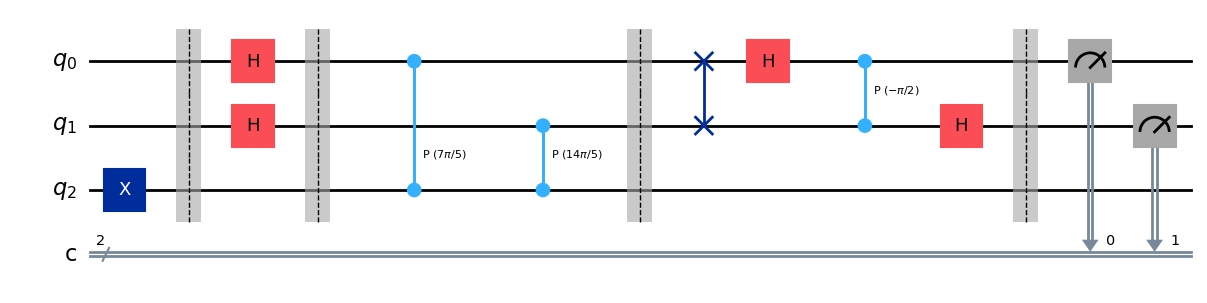

In [8]:
theta = 0.7
qc = QuantumCircuit(3, 2)

# Prepare the eigenvector
qc.x(2)
qc.barrier()

# The initial Hadamard gates
qc.h(0)
qc.h(1)
qc.barrier()

# The controlled unitary gates
qc.cp(2 * pi * theta, 0, 2)
qc.cp(2 * pi * (2 * theta), 1, 2)
qc.barrier()

# An implementation of the inverse of the two-qubit QFT
qc.swap(0, 1)
qc.h(0)
qc.cp(-pi / 2, 0, 1)
qc.h(1)
qc.barrier()

# And finally the measurements
qc.measure([0, 1], [0, 1])
display(qc.draw(output="mpl"))

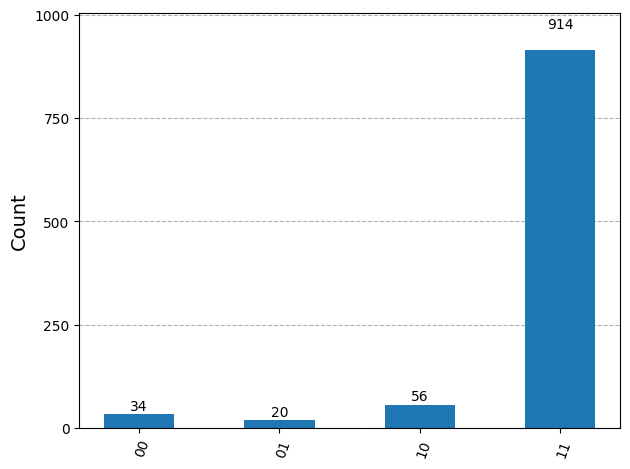

In [9]:
result = AerSimulator().run(qc).result()
statistics = result.get_counts()
display(plot_histogram(statistics))

### Generalizing to many qubits

Given the improvement we've just obtained by using two control qubits rather than one, in conjunction with the inverse of the 4-dimensional quantum Fourier transform, it's natural to consider generalizing it further — by adding more control qubits. When we do this, we obtain the general _phase estimation procedure_. We'll see how this works shortly, but in order to describe it precisely we're going to need to discuss the quantum Fourier transform in greater generality, to see how it's defined for other dimensions and to see how we can implement it (or its inverse) with a quantum circuit.



### [Quantum Fourier transform](#quantum-fourier-transform)

The quantum Fourier transform is a unitary operation that can be defined for any positive integer dimension $N$. In this subsection we'll see how this operation is defined, and we'll see how it can be implemented with a quantum circuit on $m$ qubits with cost $\mathcal{O}(m^2)$ when $N = 2^m$.

The matrices that describe the quantum Fourier transform are derived from an analogous operation on $N$-dimensional vectors known as the _discrete Fourier transform_. This operation can be thought about in different ways. For instance, we can think about the discrete Fourier transform in purely abstract, mathematical terms as a linear mapping. Or we can think about it in computational terms, where we're given an $N$-dimensional vector of complex numbers (using binary notation to encode the real and imaginary parts of the entries, let us suppose) and the goal is to calculate the $N$-dimensional vector obtained by applying the discrete Fourier transform. Our focus will be on third way, which is viewing this transformation as a unitary operation that can be performed on a quantum system, and we'll see how to build a quantum circuit to implement it.

There's an efficient algorithm for computing the discrete Fourier transform on a given input vector known as the _fast Fourier transform_. It has applications in signal processing and many other areas, and is considered by many to be one of the most important algorithms ever discovered. As it turns out, the implementation of the quantum Fourier transform when $N$ is a power of 2 that we'll study is based on precisely the same mathematical properties that make the fast Fourier transform possible.

---

### Definition of the quantum Fourier transform

To define the quantum Fourier transform, we'll first define a complex number $\omega_N$, for each positive integer $N$, like this:

$$
\omega_N = e^{2\pi i / N} = \cos\left(\frac{2\pi}{N}\right) + i \sin\left(\frac{2\pi}{N}\right).
$$

This is the number on the complex unit circle we obtain if we start at 1 and move counter-clockwise by an angle of $2\pi/N$ radians, or a fraction of $1/N$ of the circumference. Here are a few examples:

$$
\begin{aligned}
\omega_1 &= 1 \\
\omega_2 &= -1 \\
\omega_3 &= -\frac{1}{2} + \frac{\sqrt{3}}{2}i \\
\omega_4 &= i \\
\omega_8 &= \frac{1+i}{\sqrt{2}} \\
\omega_{16} &= \frac{\sqrt{2} + \sqrt{2}i}{2} + \frac{\sqrt{2} - \sqrt{2}i}{2} \\
\omega_{100} &\approx 0.998 + 0.063i
\end{aligned}
$$

We can define the $N$-dimensional quantum Fourier transform, which is described by an $N \times N$ matrix whose rows and columns are associated with the standard basis states $\{|0\rangle, \dots, |N - 1\rangle\}$. We’re only going to need this operation for when $N = 2^m$ is a power of 2 for phase estimation, but the operation can be defined for any positive integer $N$.

$$
\text{QFT}_N = \frac{1}{\sqrt{N}} \sum_{x=0}^{N-1} \sum_{y=0}^{N-1} \omega_N^{xy} |x\rangle\langle y|
$$

As was already stated, this is the matrix associated with the $N$-dimensional _discrete Fourier transform_. Often the leading factor of $1/\sqrt{N}$ is not included in the definition of this matrix, but we need to include it to obtain a unitary matrix.

---

### Examples

Here's the quantum Fourier transform, written as a matrix, for some small values of $N$:

$$\text{QFT}_1 = (1)$$

$$\text{QFT}_2 = \frac{1}{\sqrt{2}}
\begin{pmatrix}
1 & 1 \\
1 & -1
\end{pmatrix}$$

$$\text{QFT}_3 = \frac{1}{\sqrt{3}}
\begin{pmatrix}
1 & 1 & 1 \\
1 & \omega_3 & \omega_3^2 \\
1 & \omega_3^2 & \omega_3
\end{pmatrix}$$

where $\omega_3 = e^{2\pi i / 3} = -\frac{1}{2} + \frac{\sqrt{3}}{2}i$

$$\text{QFT}_4 = \frac{1}{2}
\begin{pmatrix}
1 & 1 & 1 & 1 \\
1 & i & -1 & -i \\
1 & -1 & 1 & -1 \\
1 & -i & -1 & i
\end{pmatrix}$$

$$\text{QFT}_8 = \frac{1}{2\sqrt{2}}

\begin{pmatrix}
1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 \\
1 & \omega_8 & \omega_8^2 & \omega_8^3 & \omega_8^4 & \omega_8^5 & \omega_8^6 & \omega_8^7 \\
1 & \omega_8^2 & \omega_8^4 & \omega_8^6 & 1 & \omega_8^2 & \omega_8^4 & \omega_8^6 \\
1 & \omega_8^3 & \omega_8^6 & \omega_8 & \omega_8^4 & \omega_8^7 & \omega_8^2 & \omega_8^5 \\
1 & \omega_8^4 & 1 & \omega_8^4 & 1 & \omega_8^4 & 1 & \omega_8^4 \\
1 & \omega_8^5 & \omega_8^2 & \omega_8^7 & \omega_8^4 & \omega_8 & \omega_8^6 & \omega_8^3 \\
1 & \omega_8^6 & \omega_8^4 & \omega_8^2 & 1 & \omega_8^6 & \omega_8^4 & \omega_8^2 \\
1 & \omega_8^7 & \omega_8^6 & \omega_8^5 & \omega_8^4 & \omega_8^3 & \omega_8^2 & \omega_8
\end{pmatrix}
$$

with $\omega_8 = e^{2\pi i / 8} = \frac{1 + i}{\sqrt{2}}$.

We’ll see later how to build these QFT matrices using quantum gates.



## Unitarity

Let's check that $\text{QFT}_N$ is unitary, for any selection of $N$. One way to do this is to show that its columns form an orthonormal basis. We can define a vector corresponding to column number $y$, starting from $y = 0$ and going up to $y = N - 1$, like this:

$
|\phi_y\rangle = \frac{1}{\sqrt{N}} \sum_{z=0}^{N-1} \omega_N^{yz} |z\rangle.
$

Taking the inner product between any two of these vectors gives us this expression:

$
\langle \phi_z | \phi_y \rangle = \frac{1}{N} \sum_{x=0}^{N-1} \omega_N^{x(y-z)}.
$

One way to evaluate sums like this is to use the following formula for the sum of the first $N$ terms of a geometric series:

$
1 + \alpha + \alpha^2 + \cdots + \alpha^{N-1} = 
\begin{cases}
\frac{\alpha^N - 1}{\alpha - 1} & \text{if } \alpha \ne 1 \\
N & \text{if } \alpha = 1
\end{cases}
$

Specifically, we can use this formula when $\alpha = \omega_N^{y-z}$. When $y = z$, we have $\alpha = 1$, so using the formula and dividing by $N$ gives

$
\langle \phi_y | \phi_y \rangle = 1.
$

When $y \ne z$, we have $\alpha \ne 1$, so the formula reveals this:

$
\langle \phi_z | \phi_y \rangle = \frac{1}{N} \cdot \frac{\omega_N^{N(y-z)} - 1}{\omega_N^{y-z} - 1} = \frac{1}{N} \cdot \frac{1 - 1}{\omega_N^{y-z} - 1} = 0.
$

This happens because $\omega_N^N = e^{2\pi i} = 1$, so $\omega_N^{N(y-z)} = 1^{y-z} = 1$, making numerator zero, while the denominator is nonzero because $\omega_N^{y-z} \ne 1$. At a more intuitive level, what we’re effectively doing is summing a bunch of points that are evenly spread around the unit circle, which cancel out and leave 0 when summed.

We have therefore established that $\{|\phi_0\rangle, \dots, |\phi_{N-1}\rangle\}$ is an orthonormal set,

$
\langle \phi_z | \phi_y \rangle = 
\begin{cases}
1 & y = z \\
0 & y \ne z
\end{cases}
$

which reveals that $\text{QFT}_N$ is unitary.

---

## Controlled-phase gates

To implement the quantum Fourier transform with a quantum circuit, we'll need to make use of **controlled-phase** gates. Recall from the *Single systems* lesson of *Basics of quantum information* that a *phase operation* is a single-qubit unitary operation of the form:

$
P_\alpha = 
\begin{pmatrix}
1 & 0 \\
0 & e^{i\alpha}
\end{pmatrix}
$

for any real number $\alpha$. (We used the name $\theta$ in place of $\alpha$ in that lesson, but in this lesson we're reserving the letter $\theta$ for the parameter in phase estimation.)

A controlled version of this gate has the following matrix:

## Controlled-phase gates

To implement the quantum Fourier transform with a quantum circuit, we'll need to make use of **controlled-phase** gates. Recall from the *Single systems* lesson of *Basics of quantum information* that a *phase operation* is a single-qubit unitary operation of the form:

$$
P_\alpha = 
\begin{pmatrix}
1 & 0 \\
0 & e^{i\alpha}
\end{pmatrix}
$$

for any real number $\alpha$. (We used the name $\theta$ in place of $\alpha$ in that lesson, but in this lesson we're reserving the letter $\theta$ for the parameter in phase estimation.)

A controlled version of this gate has the following matrix:

$$
CP_\alpha =
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & e^{i\alpha}
\end{pmatrix}
$$

For this controlled gate, it doesn’t actually matter which qubit is the control and which is the target because the two possibilities are equivalent. We can use any of the following symbols to represent this gate in quantum circuit diagrams:




For the third form, the label $\alpha$ is also sometimes placed on the side of the control line or under the lower control when that's convenient.

To perform the quantum Fourier transform when $N = 2^m$ and $m \geq 2$, we're going to need to perform an operation on $m$ qubits whose action on standard basis states can be described as

$$
|y\rangle |a\rangle \mapsto \omega_{2^m}^{ay} |y\rangle |a\rangle,
$$

where $a$ is a bit and $y \in \{0, \ldots, 2^{m-1} - 1\}$ is a number encoded in binary notation as a string of $m - 1$ bits. This can be done using controlled-phase gates by generalizing the following example, for which $m = 5$.



In general, for an arbitrary choice of $m \geq 2$, the top qubit corresponding to the bit $a$ can be viewed as the control, with the phase gates $P_\alpha$ ranging from $\alpha = \pi / 2^{m-1}$ on the qubit corresponding to the least significant bit of $y$ to $\alpha = \pi / 2$ on the qubit corresponding to the most significant bit of $y$. These controlled-phase gates all commute with one another and could be performed in any order.


#### Circuit implementation of the QFT

Now we’ll see how we can implement the quantum Fourier transform with a circuit when the dimension $N = 2^m$ is a power of 2. There are, in fact, multiple ways to implement the quantum Fourier transform, but this is arguably the simplest method known.

Once we know how to implement the quantum Fourier transform with a quantum circuit, it’s straightforward to implement its inverse: we can replace each gate with its inverse (or, equivalently, conjugate transpose) and apply the gates in the reverse order. Every quantum circuit composed of unitary gates alone can be inverted in this way.

The implementation is recursive in nature, and so that’s how it’s most naturally described. The base case is $m = 1$, in which case the quantum Fourier transform is a Hadamard operation.

To perform the quantum Fourier transform on $m$ qubits when $m \geq 2$, we can perform the following steps, whose actions we’ll describe for standard basis states of the form $|x\rangle |a\rangle$, where $x \in \{0, \ldots, 2^{m-1} - 1\}$ is an integer encoded as $m - 1$ bits using binary notation and $a$ is a single bit.

1. **First apply the $2^{m-1}$-dimensional quantum Fourier transform to the bottom/leftmost $m - 1$ qubits** to obtain this state:

   $$
   (\text{QFT}_{2^{m-1}} |x\rangle)|a\rangle = \frac{1}{\sqrt{2^{m-1}}} \sum_{y=0}^{2^{m-1}-1} \omega_{2^{m-1}}^{xy} |y\rangle |a\rangle.
   $$

2. **Use the top/rightmost qubit as a control** to inject the phase $\omega_{2^m}^{ay}$ for each standard basis state $|y\rangle$ of the remaining $m - 1$ qubits to obtain this state:

   $$
   \frac{1}{\sqrt{2^{m-1}}} \sum_{y=0}^{2^{m-1}-1} \omega_{2^{m-1}}^{xy} \omega_{2^m}^{ay} |y\rangle |a\rangle.
   $$

3. **Perform a Hadamard gate** on the top/rightmost qubit to obtain this state:

   $$
   \frac{1}{\sqrt{2^m}} \sum_{y=0}^{2^{m-1}-1} \sum_{b=0}^{1} (-1)^{ab} \omega_{2^{m-1}}^{xy} \omega_{2^m}^{ay} |y\rangle |b\rangle.
   $$

4. **Permute the order of the qubits** so that the least significant bit becomes the most significant bit, with all others shifted up/right:

   $$
   \frac{1}{\sqrt{2^m}} \sum_{y=0}^{2^{m-1}-1} \sum_{b=0}^{1} (-1)^{ab} \omega_{2^{m-1}}^{xy} \omega_{2^m}^{ay} |b\rangle |y\rangle.
   $$

For example, here’s the circuit we obtain for $N = 32 = 2^5$. In this diagram, the qubits are given names that



### Analysis

The key formula we need to verify that the circuit just described implements the $2^m$-dimensional quantum Fourier transform is this one:

$${(-1)}^{ab} \omega_{2^m}^{xy} \omega_{2^{m-1}}^{ay} = \omega_{2^m}^{(2x+a)(2^{m-1}b+y)}$$

This formula works for any choice of integers $a$, $b$, $x$, and $y$, but we’ll only need it for $a, b \in \{0,1\}$ and $x, y \in \{0, \dots, 2^{m-1} - 1\}$. It can be checked by expanding the product in the exponent on the right-hand side,

$$
\omega_{2^m}^{(2x+a)(2^{m-1}b+y)} = \omega_{2^m}^{2x \cdot 2^{m-1}b} \cdot \omega_{2^m}^{2xy} \cdot \omega_{2^m}^{a \cdot 2^{m-1}b} \cdot \omega_{2^m}^{ay} = (-1)^{ab} \omega_{2^m}^{xy} \omega_{2^{m-1}}^{ay},
$$

where the second equality makes use of the observation that

$$
\omega_{2^m}^{2^{m-1}b} = (\omega_{2^m}^{2^{m-1}})^b = i^b = 1^b = 1.
$$

The $2^m$-dimensional quantum Fourier transform is defined as follows for every $u \in \{0, \dots, 2^m - 1\}$:

$$
\text{QFT}_{2^m}|u\rangle = \frac{1}{\sqrt{2^m}} \sum_{v=0}^{2^m-1} \omega_{2^m}^{uv} |v\rangle
$$

If we write $u$ and $v$ as

$$
u = 2x + a \\
v = 2^{m-1}b + y
$$

for $a, b \in \{0, 1\}$ and $x, y \in \{0, \dots, 2^{m-1} - 1\}$, we obtain

$$
\text{QFT}_{2^m}|2x + a\rangle = \frac{1}{\sqrt{2^m}} \sum_{y=0}^{2^{m-1}-1} \sum_{b=0}^{1} \omega_{2^m}^{(2x+a)(2^{m-1}b+y)} |2^{m-1}b + y\rangle \\
= \frac{1}{\sqrt{2^m}} \sum_{y=0}^{2^{m-1}-1} \sum_{b=0}^{1} (-1)^{ab} \omega_{2^m}^{xy} \omega_{2^{m-1}}^{ay} |2^{m-1}b + y\rangle.
$$

Finally, by thinking about the standard basis states $|x\rangle|a\rangle$ and $|b\rangle|y\rangle$ as binary encodings of integers in the range $\{0, \dots, 2^m - 1\}$,

$$
|x\rangle|a\rangle = |2x + a\rangle \\
|b\rangle|y\rangle = |2^{m-1}b + y\rangle,
$$

we see that the circuit above implements the required operation.

If this method for performing the quantum Fourier transform seems remarkable, it's because it is! It's essentially the same methodology that underlies the fast Fourier transform in the form of a quantum circuit.


### Computational cost

Now let’s count how many gates are used in the circuit just described. The controlled-phase gates aren’t in the standard gate set that we discussed in the previous lesson, but to begin we’ll ignore this and count each of them as a single gate.

Let’s let $s_m$ denote the number of gates we need for each possible choice of $m$. If $m = 1$, the quantum Fourier transform is just a Hadamard operation, so

$$
s_1 = 1.
$$

If $m \geq 2$, then in the circuit above we need $s_{m-1}$ gates for the quantum Fourier transform on $m - 1$ qubits, plus $m - 1$ controlled-phase gates, plus a Hadamard gate, plus $m - 1$ swap gates, so

$$
s_m = s_{m-1} + (2m - 1).
$$

We can obtain a closed-form expression by summing:

$$
s_m = \sum_{k=1}^m (2k - 1) = m^2.
$$

We don’t actually need as many swap gates as the method describes. If we rearrange the gates just a bit, we can push all of the swap gates out to the right and reduce the number of swap gates required to $\lfloor m/2 \rfloor$. Asymptotically speaking this isn’t a major improvement: we still obtain circuits with size $O(m^2)$ for performing $\text{QFT}_{2^m}$.

If we wish to implement the quantum Fourier transform using only gates from our standard gate set, we need to either build or approximate each of the controlled-phase gates with gates from our set. The number required depends on how much accuracy we require, but as a function of $m$ the total cost remains quadratic. It is, in fact, possible to approximate the quantum Fourier transform quite closely with a sub-quadratic number of gates by using the fact that $P_\alpha$ is very close to the identity operation when $\alpha$ is very small — which means that we can simply leave out most of the controlled-phase gates without suffering too much of a loss in terms of accuracy.


#### QFTs in Qiskit
A circuit implementation of the QFT on any number of qubits can be obtained from Qiskit's circuit library. Note that for three or more qubits the circuit will differ slightly from the general description above because it incorporates some minor optimizations, including pushing the swap gates to the end of the circuit and adjusting the controlled-phase gates accordingly.

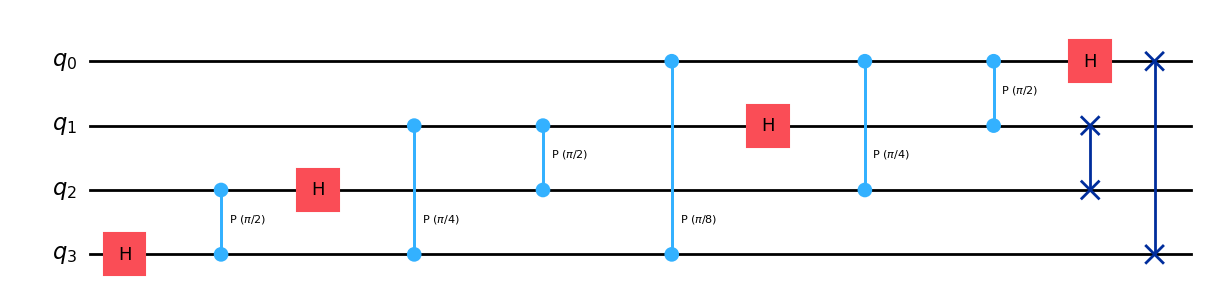

In [10]:
from qiskit.circuit.library import QFT
display(QFT(4).decompose().draw(output="mpl"))

### [General procedure and analysis](#general-procedure-and-analysis)

Now we'll examine the phase-estimation procedure in general. The idea is to extend the two-qubit version of phase estimation that we considered above in the natural way suggested by the following diagram.



Notice that for each new control qubit added on the top, we **double** the number of times the unitary operation $U$ is performed. Rather than drawing however many copies of the controlled-$U$ operation are needed to do this in the diagram, we’ve instead raised $U$ to the required powers.

In general, adding control qubits on the top like this will contribute significantly to the size of the circuit: if we have $m$ control qubits, like the diagram depicts, a total of $2^m - 1$ copies of the controlled-$U$ operation are required. This means that a **significant computational cost** is incurred as $m$ is increased — but as we will see, it also leads to a significantly more accurate approximation of $\theta$.

It is important to note, however, that for some choices of $U$ it may be possible to create a circuit that implements the operation $U^k$ for large values of $k$ in a more efficient way than simply repeating $k$ times the circuit for $U$. We’ll see a specific example of this in the context of integer factorization later in the lesson, where the efficient algorithm for *modular exponentiation* discussed in the previous lesson comes to the rescue.

---

Now let us analyze the circuit just described. The state immediately prior to the inverse quantum Fourier transform looks like this:

$$
\frac{1}{\sqrt{2^m}} \sum_{x=0}^{2^m - 1} (U^x \lvert \psi \rangle) \lvert x \rangle = \lvert \psi \rangle \otimes \frac{1}{\sqrt{2^m}} \sum_{x=0}^{2^m - 1} e^{2\pi i x \theta} \lvert x \rangle.
$$

---

### A special case

Along similar lines to what we did in the $m=2$ case above, we can consider the special case that $\theta = y / 2^m$ for $y \in \{ 0, \dots, 2^m - 1 \}$, and we see that this state can alternatively be written like this:

$$
\lvert \psi \rangle \otimes \frac{1}{\sqrt{2^m}} \sum_{x=0}^{2^m - 1} e^{2\pi i \frac{xy}{2^m}} \lvert x \rangle = \lvert \psi \rangle \otimes \frac{1}{\sqrt{2^m}} \sum_{x=0}^{2^m - 1} \omega_{2^m}^{xy} \lvert x \rangle = \lvert \psi \rangle \otimes \text{QFT}_{2^m} \lvert y \rangle.
$$

So, when the inverse quantum Fourier transform is applied, the state becomes

$$
\lvert \psi \rangle \lvert y \rangle
$$

and the measurements reveal $y$ (encoded in binary).

---

### Bounding the probabilities

For other values of $\theta$, meaning ones that don’t take the form $y / 2^m$ for an integer $y$, the measurement outcomes won’t be certain, but we can **prove bounds** on the probabilities for different outcomes. Going forward, let’s consider an arbitrary choice of $\theta$ satisfying $0 \leq \theta < 1$.

After the inverse quantum Fourier transform is performed, the state of the circuit is this:

$$
\lvert \psi \rangle \otimes \frac{1}{2^m} \sum_{y=0}^{2^m - 1} \sum_{x=0}^{2^m - 1} e^{2\pi i x(\theta - y/2^m)} \lvert y \rangle.
$$

So, when the measurements on the top $m$ qubits are performed, we see each outcome $y$ with probability

$$
p_y = \left| \frac{1}{2^m} \sum_{x=0}^{2^m - 1} e^{2\pi i x(\theta - y / 2^m)} \right|^2
$$

To get a better handle on these probabilities, we'll make use of the same formula that we saw before, for the sum of the initial portion of a geometric series.

$$
1 + \alpha + \alpha^2 + \cdots + \alpha^{N - 1} = 
\begin{cases}
\frac{\alpha^N - 1}{\alpha - 1} & \text{if } \alpha \ne 1 \\
N & \text{if } \alpha = 1
\end{cases}
$$

We can simplify the sum appearing in the formula for $p_y$ by taking $\alpha = e^{2\pi i (\theta - y / 2^m)}$. Here's what we obtain.

$$
\sum_{x=0}^{2^m - 1} e^{2\pi i x (\theta - y / 2^m)} = 
\begin{cases}
2^m & \text{if } \theta = y / 2^m \\
\frac{e^{2\pi i (2^m \theta - y)} - 1}{e^{2\pi i (\theta - y / 2^m)} - 1} & \text{if } \theta \ne y / 2^m
\end{cases}
$$

So, in the case that $\theta = y / 2^m$, we find that $p_y = 1$ (as we already knew from considering this special case), and in the case that $\theta \ne y / 2^m$, we find that

$$
p_y = \frac{1}{2^{2m}} \left| \frac{e^{2\pi i (2^m \theta - y)} - 1}{e^{2\pi i (\theta - y / 2^m)} - 1} \right|^2
$$

We can learn more about these probabilities by thinking about how arc lengths and chord lengths on the unit circle are related.  
Here's a figure that illustrates the relationships we need for any real number $\delta \in \left[ -\frac{1}{2}, \frac{1}{2} \right]$.



First, the chord length (drawn in blue) can't possibly be larger than the arc length (drawn in purple):

$$
|e^{2\pi i \delta} - 1| \leq 2\pi |\delta|.
$$

Relating these lengths in the other direction, we see that the ratio of the arc length to the chord length is greatest when $\delta = \pm 1/2$, and in this case the ratio is half the circumference of the circle divided by the diameter, which is $\pi/2$. Thus, we have:

$$
\frac{2\pi |\delta|}{|e^{2\pi i \delta} - 1|} \leq \frac{\pi}{2},
$$

and so:

$$
|e^{2\pi i \delta} - 1| \geq 4|\delta|.
$$

---

### An analysis based on these relations reveals the following two facts:

**1.** Suppose that $\theta$ is a real number and $y \in \{0, \dots, 2^m - 1\}$ satisfies

$$
\left| \theta - \frac{y}{2^m} \right| \leq 2^{-(m+1)}.
$$

This means that $y / 2^m$ is either the best $m$-bit approximation to $\theta$, or it's exactly halfway between $y / 2^m$ and either $(y - 1) / 2^m$ or $(y + 1) / 2^m$, so it's one of the two best approximations to $\theta$.

We'll prove that $p_y$ has to be pretty large in this case. By the assumption we’re considering, it follows that $|2^m \theta - y| \leq 1/2$, so we can use the second observation above relating arc and chord lengths to conclude that:

$$
|e^{2\pi i (2^m \theta - y)} - 1| \geq 4|2^m \theta - y| = 4 \cdot 2^m \cdot \left| \theta - \frac{y}{2^m} \right|.
$$

We can also use the first observation about arc and chord lengths to conclude that:

$$
|e^{2\pi i (\theta - y / 2^m)} - 1| \leq 2\pi \left| \theta - \frac{y}{2^m} \right|.
$$

Putting these two inequalities to use on $p_y$ reveals:

$$
p_y \geq \frac{1}{2^{2m}} \cdot \frac{16 \cdot 2^{2m}}{4\pi^2} = \frac{4}{\pi^2} \approx 0.405.
$$

This explains our observation that the best outcome occurs with probability greater than 40% in the $m = 2$ version of phase estimation discussed earlier. It's not really 40%, it's $4 / \pi^2$, and in fact this bound holds for every choice of $m$.

---

**2.** Now suppose that $y \in \{0, \dots, 2^m - 1\}$ satisfies

$$
2^{-m} \leq \left| \theta - \frac{y}{2^m} \right| \leq \frac{1}{2}.
$$

This means that there’s a better approximation $z / 2^m$ to $\theta$ in between $\theta$ and $y / 2^m$.

This time we’ll prove that $p_y$ can’t be too big. We can start with the simple observation that:

$$
|e^{2\pi i (2^m \theta - y)} - 1| \leq 2,
$$

which follows from the fact that any two points on the unit circle can differ in absolute value by at most 2.

We can also use the second observation about arc and chord lengths from above, this time working with the denominator of $p_y$ rather than the numerator, to conclude:

$$
|e^{2\pi i (\theta - y / 2^m)} - 1| \geq 4 \left| \theta - \frac{y}{2^m} \right| \geq 4 \cdot 2^{-m}.
$$

Putting the two inequalities together reveals:

$$
p_y \leq \frac{1}{2^{2m}} \cdot \frac{4}{\left(4 \cdot 2^{-m}\right)^2} = \frac{1}{4}.
$$

---

Note that, while this bound is good enough for our purposes, it is fairly crude — the probability is usually much lower than $1/4$.

---

#### Key Takeaways:

The important take-away from this analysis is that very close approximations to $\theta$ are likely to occur — we’ll get a best $m$-bit approximation with probability greater than **40%** — whereas approximations off by more than $2^{-m}$ are less likely to occur, with probability upper bounded by **25%**.

Given these guarantees, it is possible to boost our confidence by repeating the phase estimation procedure several times to gather statistical evidence about $\theta$.

- It is important to note that the state $|\psi\rangle$ of the bottom collection of qubits is unchanged by the phase estimation procedure.
- This allows us to run the procedure as many times as we like.

In particular:

- Each time we run the circuit, we get a best $m$-bit approximation to $\theta$ with probability **greater than 40%**.
- The probability of being off by more than $2^{-m}$ is **bounded by 25%**.
- If we run the circuit several times and take the most commonly appearing outcome of the runs, it’s therefore exceedingly likely that the outcome that appears most frequently will not be one that occurs at most 25% of the time.

As a result, we'll be very likely to obtain an approximation $y / 2^m$ that's within $1 / 2^m$ of the value $\theta$. Indeed, the unlikely chance that we're off by more than $1 / 2^m$ decreases **exponentially** in the number of times the procedure is run.

---

Here are two plots showing the probabilities for three consecutive values for $y$ when $m = 3$ and $m = 4$ as functions of $\theta$.  
(Only three outcomes are shown for clarity. Probabilities for other outcomes are obtained by cyclically shifting the same underlying function.)






In [11]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.circuit.library import QFT

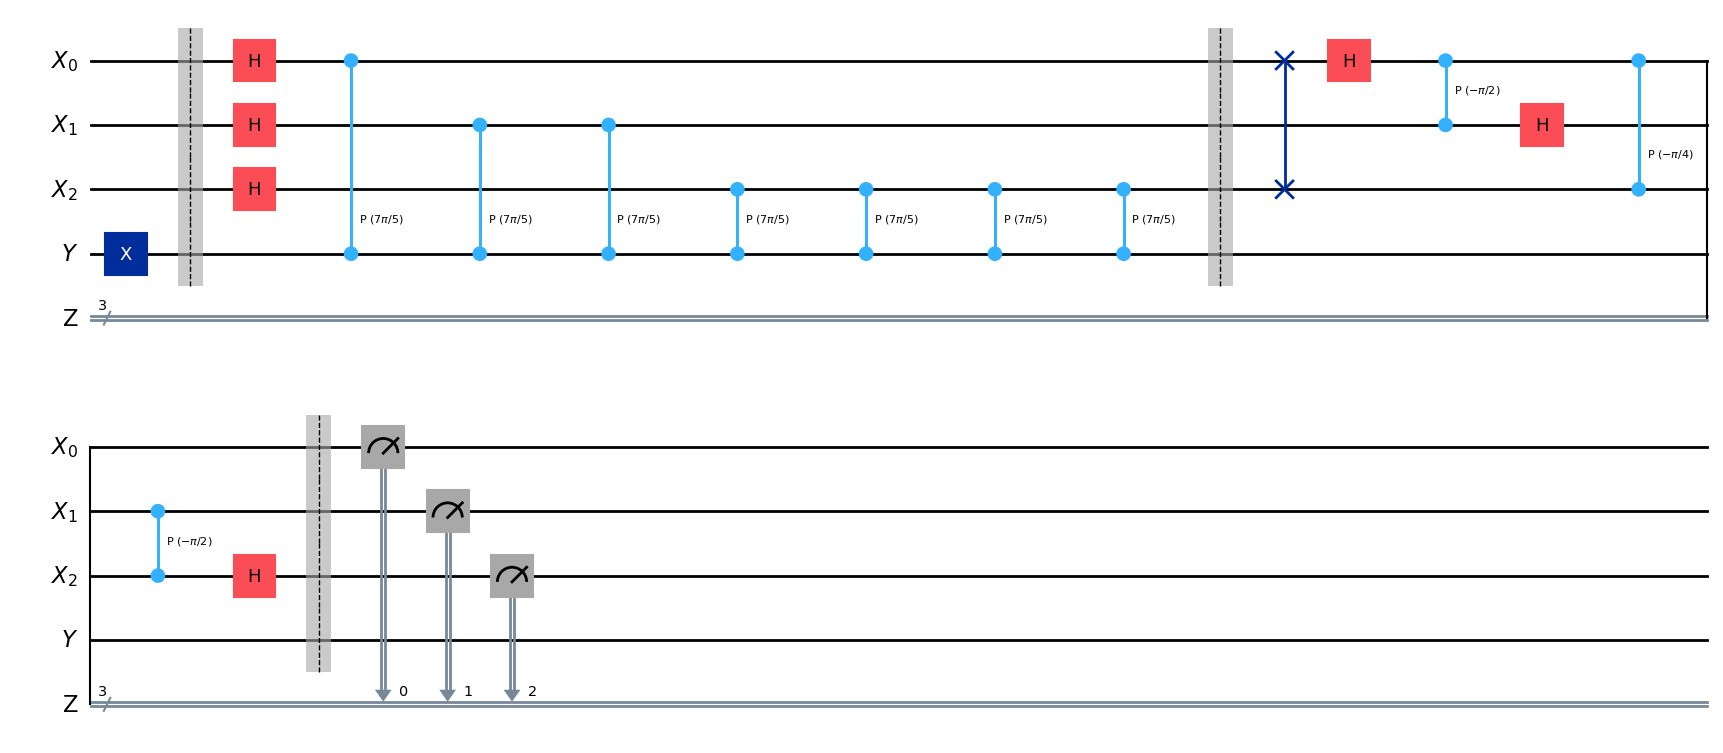

In [12]:
theta = 0.7
m = 3  # Number of control qubits

control = QuantumRegister(m, name="X")
target = QuantumRegister(1, name="Y")
output = ClassicalRegister(m, name="Z")
qc = QuantumCircuit(control, target, output)

# Prepare the eigenvector
qc.x(target)
qc.barrier()

# Perform phase estimation
for index, qubit in enumerate(control):
    qc.h(qubit)
    for _ in range(2**index):
        qc.cp(2 * pi * theta, qubit, target)
qc.barrier()

# Perform the inverse quantum Fourier transform
qc.compose(
    QFT(m, inverse=True).decompose(),
    inplace=True
)
qc.barrier()

# Measure everything
qc.measure(range(m), range(m))

display(qc.draw(output="mpl"))

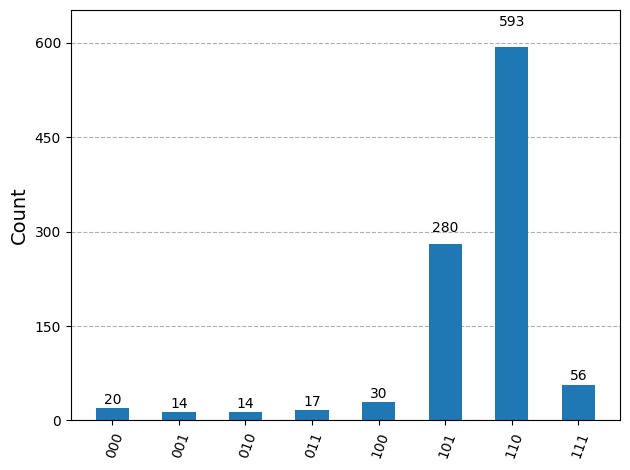

In [13]:
result = AerSimulator().run(qc).result()
statistics = result.get_counts()
display(plot_histogram(statistics))

In [14]:
most_probable = int(max(statistics, key=statistics.get),2)

print(f"Most probable output: {most_probable}")
print(f"Estimated theta: {most_probable/2**m}")

Most probable output: 6
Estimated theta: 0.75


## [Shor's algorithm](#shors-algorithm)

Now we'll turn our attention to the integer factorization problem, and see how it can be solved efficiently on a quantum computer using phase estimation. The algorithm we'll obtain is *Shor’s algorithm for integer factorization*. Shor didn’t describe his algorithm specifically in terms of phase estimation, but it is a natural and intuitive way to explain how it works. In the two subsections that follow we’ll describe the two main parts of Shor’s algorithm.

In the first subsection we’ll define an intermediate problem known as the *order-finding problem* and see how phase estimation provides a solution to this problem.

In the second subsection we’ll explain how an efficient solution to the order-finding problem also gives us an efficient solution to the integer factorization problem. When a solution to one problem provides a solution to another problem like this, we say that the second problem *reduces* to the first — so in this case we’re reducing integer factorization to order finding. This part of Shor’s algorithm doesn’t make use of quantum computing at all, it’s completely classical.

### [Order finding](#order-finding)

#### Some Basic Number Theory

To explain the order-finding problem and how it can be solved using phase estimation, it will be helpful to begin with a couple of basic number theory concepts, and to introduce some handy notation along the way.

To begin, for any given positive integer $N$, define the set $\mathbb{Z}_N$ like this:

$$
\mathbb{Z}_N = \{ 0, 1, \dots, N - 1 \}
$$

For instance:

- $\mathbb{Z}_1 = \{0\}$
- $\mathbb{Z}_2 = \{0, 1\}$
- $\mathbb{Z}_3 = \{0, 1, 2\}$, and so on.

---

These are sets of numbers, but we can think of them as more than sets. In particular, we can think about *arithmetic operations* on $\mathbb{Z}_N$ such as addition and multiplication — and if we agree to always take our answers modulo $N$ (i.e., divide by $N$ and take the remainder as the result), we’ll always stay within this set when we perform these operations.

The two specific operations of addition and multiplication, both taken modulo $N$, turn $\mathbb{Z}_N$ into a **ring**, which is a fundamentally important type of object in algebra.

---

For example, 3 and 5 are elements of $\mathbb{Z}_7$, and if we multiply them together:

$$
3 \cdot 5 = 15 \equiv 1 \pmod{7}
$$

We can also simply write:

$$
3 \cdot 5 = 1
$$

provided that it’s been made clear that we’re working in $\mathbb{Z}_7$, just to keep our notation as simple as possible.

---

### Arithmetic Tables in $\mathbb{Z}_6$

**Addition table**:

| + | 0 | 1 | 2 | 3 | 4 | 5 |
|---|---|---|---|---|---|---|
| 0 | 0 | 1 | 2 | 3 | 4 | 5 |
| 1 | 1 | 2 | 3 | 4 | 5 | 0 |
| 2 | 2 | 3 | 4 | 5 | 0 | 1 |
| 3 | 3 | 4 | 5 | 0 | 1 | 2 |
| 4 | 4 | 5 | 0 | 1 | 2 | 3 |
| 5 | 5 | 0 | 1 | 2 | 3 | 4 |

**Multiplication table**:

| × | 0 | 1 | 2 | 3 | 4 | 5 |
|---|---|---|---|---|---|---|
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
| 1 | 0 | 1 | 2 | 3 | 4 | 5 |
| 2 | 0 | 2 | 4 | 0 | 2 | 4 |
| 3 | 0 | 3 | 0 | 3 | 0 | 3 |
| 4 | 0 | 4 | 2 | 0 | 4 | 2 |
| 5 | 0 | 5 | 4 | 3 | 2 | 1 |

---

Among the $N$ elements of $\mathbb{Z}_N$, the elements $a \in \mathbb{Z}_N$ that satisfy $\gcd(a, N) = 1$ are special.  
Frequently the set containing these elements is denoted with a star like so:

$$
\mathbb{Z}_N^* = \{ a \in \mathbb{Z}_N : \gcd(a, N) = 1 \}
$$

---

If we focus our attention on the operation of multiplication, the set $\mathbb{Z}_N^*$ forms a **group** — specifically an **abelian group** — which is another important type of object in algebra. It’s a basic fact about these sets (and finite groups in general) that if we pick any element $a \in \mathbb{Z}_N^*$ and repeatedly multiply $a$ to itself, we’ll always eventually get the number 1.

### Example 1: $ N = 6 $

We have that $ 5 \in \mathbb{Z}_6^* $ because $ \gcd(5, 6) = 1 $, and if we multiply 5 to itself we get 1:

$$
5^2 = 1 \quad \text{(working within } \mathbb{Z}_6\text{)}
$$

---

### Example 2: $ N = 21 $

If we go through the numbers from 0 to 20, the ones having GCD equal to 1 with 21 are:

$$
\mathbb{Z}_{21}^* = \{1, 2, 4, 5, 8, 10, 11, 13, 16, 17, 19, 20\}
$$

For each of these elements, it is possible to raise that number to a **positive integer power** to get 1. Here are the smallest powers for which this works:

| $a$ | $r$ such that $a^r = 1$ |
|----|--------------------------|
| $1^1 = 1$ | $8^2 = 1$ | $16^3 = 1$ |
| $2^6 = 1$ | $10^6 = 1$ | $17^6 = 1$ |
| $4^3 = 1$ | $11^6 = 1$ | $19^6 = 1$ |
| $5^6 = 1$ | $13^2 = 1$ | $20^2 = 1$ |

Naturally we’re working within $\mathbb{Z}_{21}$ for all of these equations, which we haven’t bothered to write — we take it to be implicit to avoid cluttering things up. We’ll continue to do that throughout the rest of the lesson.

---

## Problem Statement

Now we can state the order-finding problem.

> **Order finding**  
> **Input:** Positive integers $ N $ and $ a $ satisfying $gcd(N, a) = 1 $
> **Output:** The smallest positive integer $ r $ such that $ a^r \equiv 1 \pmod{N} $

---

Alternatively, in terms of the notation we just introduced above, we’re given $ a \in \mathbb{Z}_N^* $, and we’re looking for the smallest positive integer $ r $ such that $ a^r = 1 $. This number $ r $ is called the **order** of $ a $ modulo $ N $.

---

## Multiplication by an element in $ \mathbb{Z}_N^* $

To connect the order-finding problem to phase estimation, let’s think about the operation defined on a system whose classical states correspond to $ \mathbb{Z}_N $, where we multiply by a fixed element $ a \in \mathbb{Z}_N^* $:

$$
M_a |x\rangle = |ax\rangle \quad \text{(for each } x \in \mathbb{Z}_N\text{)}
$$

To be clear, we’re doing the multiplication in $ \mathbb{Z}_N $, so it’s implicit that we’re taking the product modulo $ N $ inside of the ket on the right-hand side of the equation.

For example, if we take $ N = 15 $ and $ a = 2 $, then the action of $ M_2 $ on the standard basis $\{|0\rangle, \ldots, |14\rangle\}$ is as follows:

$
\begin{aligned}
M_2 |0\rangle &= |0\rangle &\quad M_2 |5\rangle &= |10\rangle &\quad M_2 |10\rangle &= |5\rangle \\
M_2 |1\rangle &= |2\rangle &\quad M_2 |6\rangle &= |12\rangle &\quad M_2 |11\rangle &= |7\rangle \\
M_2 |2\rangle &= |4\rangle &\quad M_2 |7\rangle &= |14\rangle &\quad M_2 |12\rangle &= |9\rangle \\
M_2 |3\rangle &= |6\rangle &\quad M_2 |8\rangle &= |1\rangle &\quad M_2 |13\rangle &= |11\rangle \\
M_2 |4\rangle &= |8\rangle &\quad M_2 |9\rangle &= |3\rangle &\quad M_2 |14\rangle &= |13\rangle \\
\end{aligned}
$

This is a **unitary operation** provided that $ \gcd(a, N) = 1 $; it shuffles the elements of the standard basis $ \{|0\rangle, \ldots, |N-1\rangle\} $, so as a matrix it's a **permutation matrix**. It’s evident from its definition that this operation is deterministic, and a simple way to see that it’s invertible is to think about the order $ r $ of $ a $ modulo $ N $, and to recognize that the inverse of $ M_a $ is $ M_a^{-1} $:

$
M_a^r = M_1 = I \quad \Rightarrow \quad M_a^{-1} = M_a^{r-1}
$

There's another way to think about the inverse that doesn’t require any knowledge of $ r $. For every element $ a \in \mathbb{Z}_N^* $, there’s a unique element $ b \in \mathbb{Z}_N^* $ such that $ ab = 1 $. We denote this element $ b $ by $ a^{-1} $, and it can be computed efficiently using an extended Euclidean algorithm in $ O(\log N) $ time.

So, the operation $ M_a $ is both **deterministic** and **invertible**, and that implies it’s described by a permutation matrix and is therefore **unitary**.

---

### Eigenvectors and eigenvalues of multiplication operations

Now let’s think about the eigenvectors and eigenvalues of the operation $ M_a $, assuming that $ a \in \mathbb{Z}_N^* $. As just argued, this assumption tells us that $ M_a $ is unitary.

There are $ N $ eigenvalues of $ M_a $, possibly including the same eigenvalue repeated multiple times. In general there’s some freedom in selecting the corresponding eigenvectors — but we won’t need to worry about all of the possibilities.

Let’s start simply and identify just **one eigenvector** of $ M_a $:

$
|\psi_0\rangle = \frac{1}{\sqrt{r}} \left( |1\rangle + |a\rangle + \cdots + |a^{r-1}\rangle \right)
$

The number $ r $ is the **order of $ a $ modulo $ N $**, and throughout the remainder of the lesson, the eigenvalue associated with this eigenvector is 1:

$
\begin{aligned}
M_a |\psi_0\rangle &= \frac{1}{\sqrt{r}} \left( |a\rangle + |a^2\rangle + \cdots + |a^{r-1}\rangle + |a^r\rangle \right) \\
&= \frac{1}{\sqrt{r}} \left( |a\rangle + \cdots + |a^{r-1}\rangle + |1\rangle \right) = |\psi_0\rangle
\end{aligned}
$

This happens because $ a^r = 1 $, so each standard basis state $ |a^k\rangle $ gets shifted to $ |a^{k+1}\rangle $, and $ |a^{r-1}\rangle $ gets shifted back to $ |1\rangle $. Informally speaking, it’s like we’re **slowly stirring** $ |\psi_0\rangle $, but it’s already completely stirred so nothing changes.

---

Here’s another example of an eigenvector of $ M_a $, one that is more interesting in the context of order finding and phase estimation:

$
|\psi_1\rangle = \frac{1}{\sqrt{r}} \left( |1\rangle + \omega_r^{-1} |a\rangle + \cdots + \omega_r^{-(r-1)} |a^{r-1}\rangle \right)
$

Alternatively, we can write this vector using a summation as follows:

$
|\psi_1\rangle = \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} \omega_r^{-k} |a^k\rangle
$

Here we’re seeing the complex number $ \omega_r = e^{2\pi i / r} $ showing up naturally, due to the way that multiplication by $ a $ works modulo $ N $. This time the corresponding eigenvalue is $ \omega_r $. To see this, we can first compute as follows:

$
\begin{aligned}
M_a |\psi_1\rangle &= \sum_{k=0}^{r-1} \omega_r^{-k} M_a |a^k\rangle = \sum_{k=0}^{r-1} \omega_r^{-k} |a^{k+1}\rangle \\
&= \sum_{k=1}^{r} \omega_r^{-(k-1)} |a^k\rangle = \omega_r \sum_{k=1}^{r} \omega_r^{-k} |a^k\rangle
\end{aligned}
$

Then, because $ \omega_r^{-r} = 1 $ and $ a^r = 1 \Rightarrow |a^r\rangle = |1\rangle = |a^0\rangle $, we see that:

$
\sum_{k=1}^{r} \omega_r^{-k} |a^k\rangle = \sum_{k=0}^{r-1} \omega_r^{-k} |a^k\rangle = |\psi_1\rangle
$

So,

$
M_a |\psi_1\rangle = \omega_r |\psi_1\rangle
$

---

Using the same reasoning, we can identify additional eigenvector/eigenvalue pairs for $ M_a $. For any choice of $ j \in \{0, \ldots, r-1\} $, we have that:

$
|\psi_j\rangle = \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} \omega_r^{-jk} |a^k\rangle
$

is an eigenvector of $ M_a $, whose corresponding eigenvalue is $ \omega_r^j $:

$
M_a |\psi_j\rangle = \omega_r^j |\psi_j\rangle
$

There are other eigenvectors of $ M_a $, but we don’t need to concern ourselves with them — we’ll focus solely on the eigenvectors $ |\psi_0\rangle, \ldots, |\psi_{r-1}\rangle $ that we’ve just identified.

---

### Applying phase estimation

To solve the order-finding problem for a given choice of $ a \in \mathbb{Z}_N^* $, we can apply the phase-estimation procedure to the operation $ M_a $.

To do this, we need to implement not only $ M_a $ efficiently with a quantum circuit, but also $ M_a^2, M_a^4, M_a^8 $, and so on, going as far as needed to obtain a precise enough estimate from the phase estimation procedure. Here we’ll explain how this can be done, and we’ll figure out exactly how much precision is needed later.

Let’s start with the operation $ M_a $ by itself. Naturally, because we’re working with the quantum circuit model, we’ll use binary notation to encode the numbers between 0 and $ N-1 $. The largest number we need to encode is $ N - 1 $, so the number of bits we need is:

$
n = \lfloor \log(N - 1) \rfloor + 1
$

For example, if $ N = 21 $, we have $ n = \lfloor \log(20) \rfloor + 1 = 5 $. Here’s what the encoding of elements of $ \mathbb{Z}_{21} $ as binary strings of length 5 looks like.

For example, if $ N = 21 $ we have $ n = \lfloor \log(N - 1) \rfloor + 1 = 5 $. Here's what the encoding of elements of $ \mathbb{Z}_{21} $ as binary strings of length 5 looks like:

$
\begin{aligned}
0 &\mapsto 00000 \\
1 &\mapsto 00001 \\
\vdots \\
20 &\mapsto 10100
\end{aligned}
$

---

And now, here's a precise definition of how $ M_a $ is defined as an $ n $-qubit operation:

$
M_a |x\rangle = 
\begin{cases}
|ax \mod N\rangle & \text{if } 0 \leq x < N \\
|x\rangle & \text{if } N \leq x < 2^n
\end{cases}
$

The point is that although we only care about how $ M_a $ works for $ \{0, \ldots, N - 1\} $, we do have to specify how it works for the remaining $ 2^n - N $ standard basis states — and we need to do this in a way that still gives us a unitary operation. Defining $ M_a $ so that it does nothing to the remaining standard basis states accomplishes this.

---

Using the algorithms for integer multiplication and division discussed in the previous lesson, together with the methodology for reversible, garbage-free implementations of them, we can build a quantum circuit that performs $ M_a $, for any choice of $ a \in \mathbb{Z}_N^* $, at cost $ O(n^2) $. Here's one way that this can be done:

1. **Build a circuit for performing the operation**

$
|x\rangle |y\rangle \mapsto |x\rangle |y \oplus f_a(x)\rangle
$

where

$
f_a(x) = 
\begin{cases}
ax \mod N & \text{if } 0 \leq x < N \\
x & \text{if } N \leq x < 2^n
\end{cases}
$

using the method described in the previous lesson. This gives us a circuit of size $ O(n^2) $.

2. **Swap** the two $ n $-qubit systems using $ n $ swap gates to swap the qubits individually.

3. **Along similar lines to the first step**, build a circuit for the operation:

$
|x\rangle |y\rangle \mapsto |x\rangle |y \oplus f_a^{-1}(x)\rangle
$

where $ a^{-1} $ is the inverse of $ a \in \mathbb{Z}_N^* $.

---

By initializing the bottom $ n $ qubits and composing the three steps, we obtain this transformation:

$
\begin{aligned}
|x\rangle |0\rangle 
&\xrightarrow{\text{step 1}} |x\rangle |f_a(x)\rangle 
\xrightarrow{\text{step 2}} |f_a(x)\rangle |x\rangle 
\xrightarrow{\text{step 3}} |f_a(x)\rangle |x \oplus f_a^{-1}(f_a(x))\rangle 
= |f_a(x)\rangle |0\rangle
\end{aligned}
$

---

The method requires workspace qubits, but they’re returned to their initialized state at the end, which allows us to use these circuits for phase estimation. The total cost of the circuit we obtain is $ O(n^2) $.

---

To perform $ M_a^2, M_a^4, M_a^8 $, and so on, we can use exactly the same method, except that we replace $ a $ with $ a^2, a^4, a^8 $, and so on, as elements of $ \mathbb{Z}_N^* $. That is, for any power $ k $ we choose, we can create a circuit for $ M_a^k $ not by iterating $ k $ times the circuit for $ M_a $, but instead by computing $ b = a^k \in \mathbb{Z}_N^* $, and then using the circuit for $ M_b $.

The computation of powers $ a^k \in \mathbb{Z}_N $ is the **modular exponentiation** problem mentioned in the previous lesson. This computation can be done *classically*, using the algorithm for modular exponentiation mentioned in the previous lesson (often called the *power algorithm* in computational number theory). In fact, we only require power-of-2 powers of $ a $, in particular $ a^2, a^4, \ldots, a^{2^{m-1}} \in \mathbb{Z}_N^* $, which we can obtain using $ m-1 $ squarings. Each squaring can be performed by a Boolean circuit of size $ O(n^2) $.


## A convenient eigenvector/eigenvalue pair

To understand how we can solve the order-finding problem using phase estimation, let’s start by supposing that we run the phase estimation procedure on the operation $ M_a $ using the eigenvector $ |\psi_1\rangle $. Getting our hands on this eigenvector isn’t easy, as it turns out, so this won’t be the end of the story — but it’s helpful to start here.

The eigenvalue of $ M_a $ corresponding to the eigenvector $ |\psi_1\rangle $ is:

$
\omega_r = e^{2\pi i \cdot \frac{1}{r}}
$

That is, $ \omega_r = e^{2\pi i \theta} $ for $ \theta = \frac{1}{r} $. So, if we run the phase estimation procedure on $ M_a $ using the eigenvector $ |\psi_1\rangle $, we’ll get an approximation to $ \frac{1}{r} $. By computing the reciprocal we’ll be able to learn $ r $ — provided that our approximation is good enough.

---

To be more precise, when we run the phase-estimation procedure using $ m $ control qubits, what we obtain is a number $ y \in \{0, \ldots, 2^m - 1\} $, and we take $ y / 2^m $ as a guess for $ \theta $, which is $ 1/r $ in the case at hand. To figure out what $ r $ is from this approximation, the natural thing to do is to compute the reciprocal of our approximation and round to the nearest integer:

$
\left\lfloor \frac{2^m}{y} + \frac{1}{2} \right\rfloor
$

---

For example, let's suppose $ r = 6 $ and we perform phase estimation on $ M_a $ with the eigenvector $ |\psi_1\rangle $ using $ m = 5 $ control bits.  
The best 5-bit approximation to $ \frac{1}{r} = \frac{1}{6} $ is $ \frac{5}{32} $, and we have a pretty good chance (about 68% in this case) to obtain the outcome $ y = 5 $ from phase estimation. We have:

$
\frac{2^m}{y} = \frac{32}{5} = 6.4
$

and rounding to the nearest integer gives **6**, which is the correct answer.

---

On the other hand, if we don’t use enough precision, we might not get the right answer. For instance, if we take $ m = 4 $ control qubits in phase estimation, we might obtain the best 4-bit approximation to $ \frac{1}{r} = \frac{1}{6} $, which is $ \frac{3}{16} $. Taking the reciprocal yields:

$
\frac{2^m}{y} = \frac{16}{3} \approx 5.333\ldots
$

and rounding to the nearest integer gives an incorrect answer of **5**.

---

So how much precision do we need to get the right answer? We know that the order $ r $ is an integer, and intuitively speaking what we need is enough precision to distinguish $ 1/r $ from nearby possibilities, including $ 1/(r + 1) $ and $ 1/(r - 1) $.  
The closest number to $ 1/r $ that we need to be concerned with is $ 1/(r + 1) $, and the distance between these two numbers is:

$
\frac{1}{r} - \frac{1}{r + 1} = \frac{1}{r(r + 1)}
$

---

So, if we want to make sure that we don’t mistake $ 1/r $ for $ 1/(r + 1) $, it suffices to use enough precision to guarantee that a best approximation $ y / 2^m $ to $ 1/r $ is closer to $ 1/r $ than it is to $ 1/(r + 1) $. If we use enough precision so that:

$
\left| \frac{y}{2^m} - \frac{1}{r} \right| < \frac{1}{2r(r + 1)},
$

so that the error is less than half of the distance between $1/r$ and $1/(r+1)$, then $y/2^m$ will be closer to $1/r$ than any other possibility, inclusing $1/(r+1)$ and $1/(r-1)$

We can double-check this as follows. Suppose that

$
\frac{y}{2^m} = \frac{1}{r} + \varepsilon
$

for $ \varepsilon $ satisfying

$
|\varepsilon| < \frac{1}{2r(r + 1)}.
$

When we take the reciprocal, we obtain:

$
\frac{2^m}{y} = \frac{1}{\frac{1}{r} + \varepsilon} = \frac{r}{1 + \varepsilon r} = r - \frac{\varepsilon r^2}{1 + \varepsilon r}.
$

By maximizing the numerator and minimizing the denominator, we can bound how far away we are from $ r $ as follows:

$
\left| \frac{\varepsilon r^2}{1 + \varepsilon r} \right| \leq \frac{r^2}{1 - \frac{1}{2r(r+1)}} = \frac{r}{2r + 1} < \frac{1}{2}.
$

We're less than $ \frac{1}{2} $ away from $ r $, so as expected we’ll get $ r $ when we round.

---

Unfortunately, because we don’t yet know what $ r $ is, we can’t use it to tell us how much accuracy we need. What we can do instead is to use the fact that $ r $ must be smaller than $ N $ to ensure that we use enough precision. In particular, if we use enough accuracy to guarantee that the best approximation $ \frac{y}{2^m} $ to $ \frac{1}{r} $ satisfies

$
\left| \frac{y}{2^m} - \frac{1}{r} \right| \leq \frac{1}{2N^2},
$

then we’ll have enough precision to correctly determine $ r $ when we take the reciprocal. Taking $ m = 2\log(N) + 1 $ ensures that we have a high chance to obtain an estimation with this precision using the method described previously.  
(Taking $ m = 2\log(N) $ is good enough if we're comfortable with a lower-bound of 40% on the probability of success.)

---

## Other eigenvector/eigenvalue pairs

As we just saw, if we have the eigenvector $ |\psi_1\rangle $ of $ M_a $, we can learn $ r $ through phase estimation, so long as we use enough control qubits to do this with sufficient precision. Unfortunately, it's not easy to get our hands on the eigenvector $ |\psi_1\rangle $, so we need to figure out how to proceed.

Let's suppose we proceed just like we did above, except with the eigenvector $ |\psi_k\rangle $ in place of $ |\psi_1\rangle $, for any choice of $ k \in \{0, \ldots, r - 1\} $ that we choose to think about. The result we get from the phase estimation procedure will be an approximation

$
\frac{y}{2^m} \approx \frac{k}{r}.
$

Working under the assumption that we don’t know either $ k $ or $ r $, this might or might not allow us to identify $ r $. For example, if $ k = 0 $ we’ll get an approximation $ \frac{y}{2^m} \approx 0 $, which unfortunately tells us nothing. This, however, is an unusual case; for other values of $ k $, we’ll at least be able to learn something about $ r $.

---

We can use an algorithm known as the **continued fraction algorithm** to expand the approximation $ y / 2^m $ into nearby fractions — including $ k / r $ if the approximation is good, which will allow us to then continue this fraction algorithm. Indeed, here’s a statement in known form about this algorithm.

> **Fact.** Given an integer $ N \geq 2 $ and a real number $ \alpha \in (0, 1) $, there is at most one choice of integers $ u, v \in \{0, \ldots, N - 1\} $ with $ v \neq 0 $ and $ \gcd(u, v) = 1 $ satisfying $ \left| \alpha - \frac{u}{v} \right| < \frac{1}{2N} $.  
> Given $ \alpha $ and $ N $, the **continued fraction algorithm** finds $ u $ and $ v $, or reports that they don’t exist. This algorithm can be implemented as a Boolean circuit having size $ O((\log(Nv))^3) $.

---

If we have a very close approximation $ \frac{y}{2^m} \approx \frac{k}{r} $, and we run the continued fraction algorithm for $ N $ and $ \alpha = \frac{y}{2^m} $, we’ll get $ u $ and $ v $, as they’re described in the fact. An analysis of the fact allows us to conclude that:

$
\frac{u}{v} = \frac{k}{r}.
$

So we don’t necessarily learn $ k $ and $ r $, we only learn $ \frac{k}{r} $ in lowest terms.

For example, and as we’ve already noticed, we’re not going to learn anything from $ k = 0 $. But that’s the only value of $ k $ where that happens. When $ k $ is nonzero, it might have common factors with $ r $, but the number $ v $ we obtain from the continued fraction algorithm must at least divide $ r $.

It’s far from obvious, but it is true that if we have the ability to learn $ u $ and $ v $ for $ u/v = k/r $ for $ k \in \{0, \ldots, r - 1\} $ chosen *uniformly at random*, then we’re very likely to be able to recover $ r $ after just a few samples. In particular, if our guess for $ r $ is the **least common multiple** of all the values for the denominator $ v $ that we observe, we’ll be right with high probability.

Intuitively speaking, some values of $ k $ aren’t good because they share common factors with $ r $, and those common factors are hidden to us when we learn $ u $ and $ v $. But **random** choices of $ k $ aren’t likely to hide factors of $ r $ for long, and the probability that we don’t guess $ r $ correctly by taking the least common multiple of the denominators we observe drops exponentially in the number of samples.

---

## Proceeding without an eigenvector

So far we haven’t addressed the issue of how we get our hands on an eigenvector $ |\psi_k\rangle $ of $ M_a $ to run the phase estimation procedure on. As it turns out, we don’t need to create them. What we will do instead is to run the phase estimation procedure on the state $ |1\rangle $, by which we mean the $ n $-bit binary encoding of the number 1, in place of an eigenvector $ |\psi\rangle $ of $ M_a $.

So far, we’ve only talked about running the phase estimation procedure on a particular eigenvector, but nothing prevents us from running the procedure on an input state that isn’t an eigenvector of $ M_a $, and that’s what we’re doing here with the state $ |1\rangle $. (This isn’t an eigenvector of $ M_a $ unless $ a = 1 $, which isn’t a choice we’ll be interested in.)

The reason for choosing the state $ |1\rangle $ in place of an eigenvector of $ M_a $ is that the following equation is true:

$
|1\rangle = \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} |\psi_k\rangle
$

One way to verify this equation is to compare the inner products of the two sides with each standard basis state, using formulas mentioned previously in the lesson to help to evaluate the results for the right-hand side. As a result, we will obtain precisely the same measurement results as if we had chosen $ k \in \{0, \ldots, r - 1\} $ uniformly at random and used $ |\psi_k\rangle $ as an eigenvector.

In greater detail, let’s imagine that we run the phase estimation procedure with the state $ |1\rangle $ in place of one of the eigenvectors $ |\psi_k\rangle $. After the quantum Fourier transform is performed, this leaves us with the state

$
\frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} |\psi_k\rangle |\gamma_k\rangle,
$

where

$
|\gamma_k\rangle = \frac{1}{2^m} \sum_{y=0}^{2^m - 1} e^{2\pi i (k/r - y/2^m)} |y\rangle.
$


---

### Total cost

The cost to implement each controlled-unitary $ M_a^{k} $ is $ O(n^2) $. There are $ m $ controlled-unitary operations, and we have $ m = O(n) $, so the total cost for the controlled-unitary operations is $ O(n^3) $. In addition, we have $ m $ Hadamard gates (which contribute $ O(n) $ to the cost), and the inverse quantum Fourier transform contributes $ O(n^2) $ to the cost. Thus, the cost of the controlled-unitary operations dominates the cost of the entire procedure — which is therefore $ O(n^3) $.

In addition to the quantum circuit itself, there are a few classical computations that need to be performed along the way. This includes computing the powers $ a^k \in \mathbb{Z}_N $ for $ k = 2, 4, 8, \ldots, 2^{m-1} $, which are needed to create the controlled-unitary gates, as well as the continued fraction algorithm that converts approximations of $ \theta $ into fractions. These computations can be performed by Boolean circuits with a total cost of $ O(n^3) $.

As is typical, all of these bounds can be improved using asymptotically fast algorithms; these bounds assume we're using standard algorithms for basic arithmetic operations.




### [Factoring by order-finding](#factoring-by-order-finding)


The very last thing we need to discuss is how solving the order-finding problem helps us to factor. This part is completely classical — it has nothing specifically to do with quantum computing.

Here's the basic idea. We want to factorize the number $ N $, and we can do this *recursively*. Specifically, we can focus on the task of **splitting** $ N $, which means finding any two integers $ b, c \geq 2 $ for which $ N = bc $. This isn't possible if $ N $ is a prime number, but we can efficiently test to see if $ N $ is prime using a primality testing algorithm first, and if $ N $ isn't prime we'll try to split it. Once we split $ N $, we can simply recurse on $ b $ and $ c $ until all of our factors are prime and we obtain the prime factorization of $ N $.

Splitting even integers is easy: we just output $ 2 $ and $ N / 2 $.

It's also easy to split perfect powers, meaning numbers of the form $ N = s^j $ for integers $ s, j \geq 2 $, just by approximating the roots $ N^{1/2}, N^{1/3}, N^{1/4}, $ etc., and checking nearby integers as suspects for $ s $. We don't need to go further than $ \log(N) $ steps into this sequence, because at that point the root drops below 2 and won't reveal additional candidates.

It's good that we can do both of these things because order-finding won't help us to factor even numbers or for *prime* powers, where the number $ s $ happens to be prime. If $ N $ is odd and not a prime power, however, order-finding allows us to split $ N $.

---

> ### **Probabilistic algorithm to split an odd, composite integer N that is not a prime power**
> 
> 1. Randomly choose $ a \in \{2, \ldots, N - 1\} $.
> 2. Compute $ d = \gcd(a, N) $.
> 3. If $ d > 1 $, then output $ b = d $ and $ c = N / d $ and stop. Otherwise continue to the next step knowing that $ a \in \mathbb{Z}_N^* $.
> 4. Let $ r $ be the order of $ a $ modulo $ N $. (Here's where we need order-finding.)
>     5. If $ r $ is even:
>         - 5.1 Compute $ x = a^{r/2} - 1 \mod N $
>         - 5.2 Compute $ d = \gcd(x, N) $.
>         - 5.3 If $ d > 1 $ then output $ b = d $ and $ c = N / d $ and stop.
> 6. If this point is reached, the algorithm has failed to find a split of $ N $.

---

### Why this works

Suppose we’re in step 5 of the factoring algorithm and we’ve found an even order $ r $ such that $ a^{r} \equiv 1 \mod N $. That implies

$
a^{r} - 1 \equiv 0 \mod N \quad \text{or} \quad (a^{r/2} - 1)(a^{r/2} + 1) \equiv 0 \mod N.
$

This means that $ N $ divides the product $ (a^{r/2} - 1)(a^{r/2} + 1) $, but (with good probability) doesn’t divide either factor on its own. So if we compute:

- $ x = a^{r/2} \mod N $
- Then $ \gcd(x - 1, N) $ and $ \gcd(x + 1, N) $

we have a good chance of getting a non-trivial factor of $ N $.

This is the quantum core of **Shor’s algorithm**: it uses the quantum Fourier transform to find the period $ r $, and the classical part then uses this period to factor $ N $ based on the identity:

$
a^{r} \equiv 1 \mod N \quad \Rightarrow \quad a^{r} - 1 \equiv 0 \mod N.
$

Factoring $ a^{r} - 1 $ (modulo $ N $) into the difference of squares:

$
a^{r} - 1 = (a^{r/2} - 1)(a^{r/2} + 1)
$

lets us extract nontrivial factors of $ N $, completing the algorithm.

---



We'll conclude the lesson by implementing Shor's algorithm in Qiskit — with a caveat to be explained first.

To factor a positive integer $N$ Shor's algorithm requires an implementation of the operation 
$M_b$ for various elements $b \in \Zeta_N^*$
​
This can be done (using workspace qubits) as described above, based on the methodology explained in the Quantum algorithmic foundations lessons. But actually constructing quantum circuits for these operations is rather laborious and won't be done here. (It would make for an interesting project, though.) Instead, what we'll do is to create explicit matrix representations of these operations and then use Qiskit's UnitaryGate function, which converts the matrix into a custom gate that can be used in a quantum circuit.

We can then ask the Qiskit transpiler to convert these custom gates into an actual quantum circuit. This is terribly inefficient — it requires time exponential in $n$ and results in very large circuits in general — but this is the price we're paying to avoid the work of having to explicitly construct efficient modular multiplication circuits. So, this doesn't represent a true implementation of Shor's algorithm in this regard, but it does offer a reasonably general demonstration for the purposes of the lesson while keeping the coding simple (and doing something fun with Qiskit).

In [15]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library import UnitaryGate
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator
import numpy as np
from math import gcd, floor, log
from fractions import Fraction
import random

In [16]:
def mod_mult_gate(b,N):
    if gcd(b,N)>1:
        print(f"Error: gcd({b},{N}) > 1")
    else:
        n = floor(log(N-1,2)) + 1
        U = np.full((2**n,2**n),0)
        for x in range(N): U[b*x % N][x] = 1
        for x in range(N,2**n): U[x][x] = 1
        G = UnitaryGate(U)
        G.name = f"M_{b}"
        return G

In [17]:
def order_finding_circuit(a,N):
    if gcd(a,N)>1:
        print(f"Error: gcd({a},{N}) > 1")
    else:
        n = floor(log(N-1,2)) + 1
        m = 2*n

        control = QuantumRegister(m, name = "X")
        target = QuantumRegister(n, name = "Y")
        output = ClassicalRegister(m, name = "Z")
        circuit = QuantumCircuit(control, target, output)

        # Initialize the target register to the state |1>
        circuit.x(m)

        # Add the Hadamard gates and controlled versions of the
        # multiplication gates
        for k, qubit in enumerate(control):
            circuit.h(k)
            b = pow(a,2**k,N)
            circuit.compose(
                mod_mult_gate(b,N).control(),
                qubits = [qubit] + list(target),
                inplace=True)

        # Apply the inverse QFT to the control register
        circuit.compose(
            QFT(m, inverse=True),
            qubits=control,
            inplace=True)

        # Measure the control register
        circuit.measure(control, output)

        return circuit

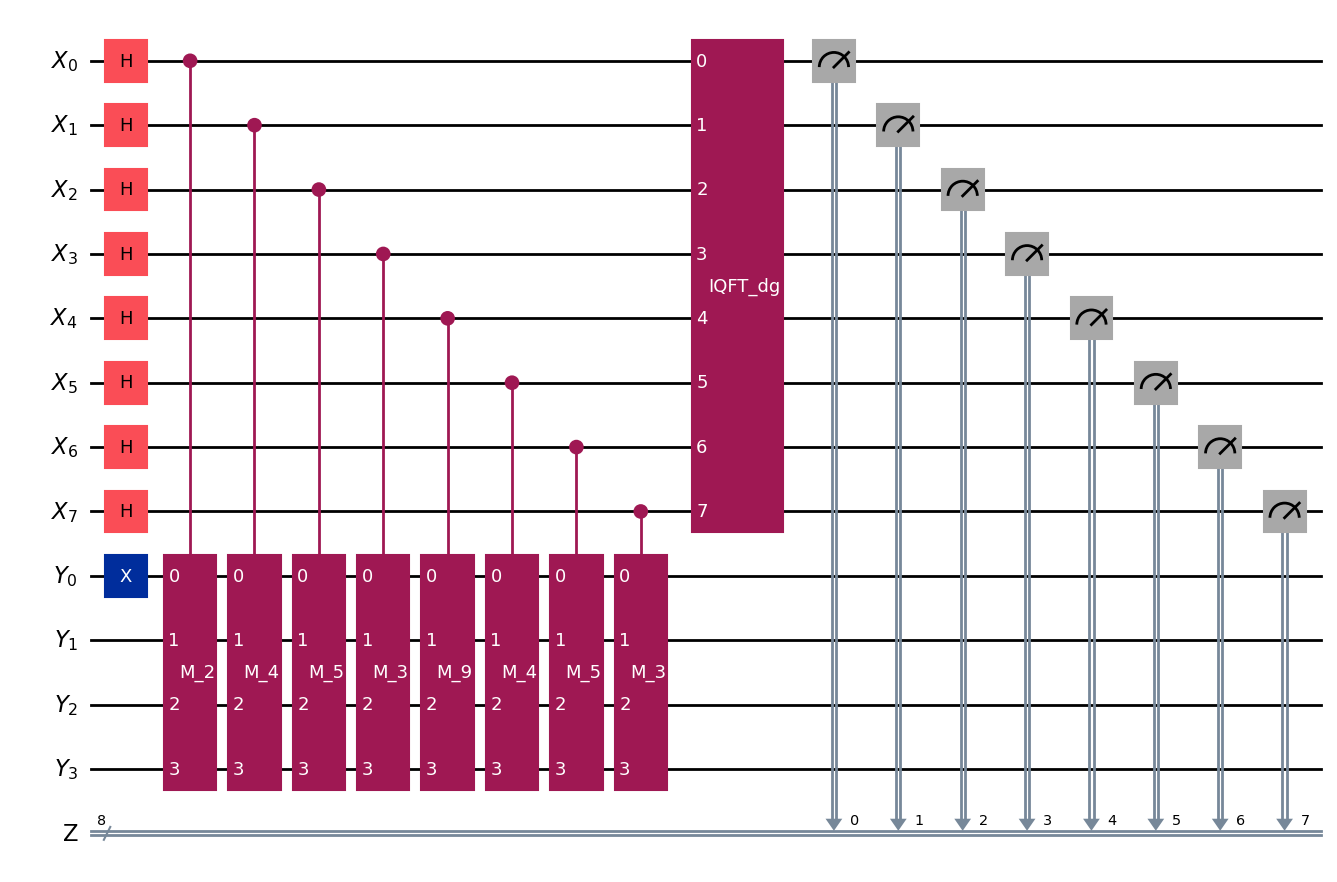

In [18]:
order_finding_circuit(2,11).draw(output = "mpl")

We can now define a function `find_order` that runs the order-finding circuit and determines the order of a given element $ \alpha \in \mathbb{Z}_N^\times $\)$ using phase estimation together with the continued fraction algorithm. This function can take a while to run, owing in part to the transpilation of the order-finding circuit that includes our custom modular multiplication gates. We're asking the transpiler to do what we decided was too laborious — and without using workspace qubits!


In [19]:
def find_order(a,N):
    if gcd(a,N)>1:
        print(f"Error: gcd({a},{N}) > 1")
    else:
        n = floor(log(N-1,2)) + 1
        m = 2*n
        circuit = order_finding_circuit(a,N)
        transpiled_circuit = transpile(circuit,AerSimulator())

        while True:
            result = AerSimulator().run(
                transpiled_circuit,
                shots=1,
                memory=True).result()
            y = int(result.get_memory()[0],2)
            r = Fraction(y/2**m).limit_denominator(N).denominator
            if pow(a,r,N)==1: break
        return r

In [20]:
N = 11
a = 2
print(f"The order of {a} modulo {N} is {find_order(a,N)}.")

The order of 2 modulo 11 is 10.


In [21]:
N = 39

FACTOR_FOUND = False

# First we'll check to see if N is even or a nontrivial power.
# Order finding won't help for factoring a *prime* power, but
# we can easily find a nontrivial factor of *any* nontrivial
# power, whether prime or not.

if N % 2 == 0:
    print("Even number")
    d = 2
    FACTOR_FOUND = True
else:
    for k in range(2,round(log(N,2))+1):
        d = int(round(N ** (1/k)))
        if d**k == N:
            FACTOR_FOUND = True
            print("Number is a power")
            break

# Now we'll iterate until a nontrivial factor of N is found.

while not FACTOR_FOUND:
    a = random.randint(2,N-1)
    d = gcd(a,N)
    if d>1:
        FACTOR_FOUND = True
        print(f"Lucky guess of {a} modulo {N}")
    else:
        r = find_order(a,N)
        print(f"The order of {a} modulo {N} is {r}")
        if r % 2 == 0:
            x = pow(a,r//2,N) - 1
            d = gcd(x,N)
            if d>1: FACTOR_FOUND = True

print(f"Factor found: {d}")

Lucky guess of 6 modulo 39
Factor found: 3
